---

# Task:

Here we will approach the challenge of understanding (and potentially predicting) food insecurity using the provided (limited) data.


## Provided Data:

1. **Risk Factors:** A file containing 167 risk factors (unigrams, bigrams, and trigrams) in the `english_keywords` column and an empty `keywords_arabic` column. A separate file with the mapping of English risk factors to pre-defined thematic cluster assignments.


2. **News Articles:** Two files containing one month of news articles from the Mashriq region:
   - `news-articles-eng.csv`
   - `news-articles-ara.csv`
   - **Note:** You may work on a sample subset during development.
   
   
3. **Geographic Taxonomy:** A file containing the names of the countries, provinces, and districts for the subset of Mashriq countries that is covered by the news articles. The files are a dictionary mapping from a key to the geographic name.
   - `id_arabic_location_name.pkl`
   - `id_english_location_name.pkl`
   - **Note:** Each unique country/province/district is assigned a key (e.g. `iq`,`iq_bg` and `iq_bg_1` for country Iraq, province Baghdad, and district 1 in Baghdad respectively).
   - The key of country names is a two character abbreviation as follows.
       - 'iq': 'Iraq'
       - 'jo': 'Jordan'
       - 'lb': 'Lebanon'
       - 'ps': 'Palestine'
       - 'sy': 'Syria'
       
   - The key of provinces is a two-character abbreviation of the country followed by two-character abbreviation of the province **`{country_abbreviation}_{province_abbreviation}`**, and the key of districts is **`{country_abbreviation}_{province_abbreviation}_{unique_number}`**.
       


---

### Data Inspection

Given this highly open-ended task of understanding food insecurity given these limited data sources, let us first get to know--and clean--the provided data. 

In [3]:
"""Load and clean risk factors data."""
import pandas as pd
import os

NUM_GIVEN_RISK_FACTORS = 167

# Create intermediate directory for cleaned dataif it doesn't exist
INTERMEDIATE_DIR = './intermediate'
os.makedirs(INTERMEDIATE_DIR, exist_ok=True)

# Read in the risk factors and categories and *manually* fix apparent encoding issues
risk_factors = pd.read_excel('data/risk-factors.xlsx')
risk_factors.iloc[143] = ["coup d'etat", None] # Fix the "d\etat" problem
risk_factors_categories = pd.read_excel('data/risk-factors-categories.xlsx')
risk_factors_categories['risk_factor'] = risk_factors_categories['risk_factor'].astype(str).str.replace("d'etat", "coup d'etat")

# Join the dataframes by 'risk_factor_english' from risk-factors and 'risk_factor' from risk-factors-categories
merged_risk_factors = pd.merge(risk_factors, risk_factors_categories, left_on='risk_factor_english', right_on='risk_factor', how='left', validate='one_to_one')
merged_risk_factors = merged_risk_factors.drop('risk_factor', axis=1)
merged_risk_factors = merged_risk_factors.sort_values(by='cluster')
merged_risk_factors.rename(columns={'cluster': 'cluster_english'}, inplace=True)
assert len(merged_risk_factors) == NUM_GIVEN_RISK_FACTORS # As per instructions
assert merged_risk_factors[['risk_factor_english', 'cluster_english']].isna().sum().sum() == 0 # No missing (english) names or clusters

While we have a nicely merged English-language list of risk factors and their associated grouping, we are missing the corresponding names of these risk factors in Arabic. To avoid manual hassle and also enforce some (albeit imperfect) consistency into the naming, let's make the same API request to fill in each Arabic risk factor and cluster.

In [ ]:
from openai import OpenAI, OpenAIError
from concurrent.futures import ThreadPoolExecutor

# Look for OPENAI_API_KEY environment variable to make requests
client = OpenAI(timeout=30)

def make_openai_request(instructions: str, prompt: str, model: str = "gpt-4o-mini") -> str:
    """OpenAI API request wrapper with relevant system prompt.
    
    Args:
        instructions: (str) of the system prompt.
        prompt: (str) of the user prompt.
        model: (str) of the OpenAI model to use.

    Returns:
        (str) of the OpenAI API request response
    """
    try:
        response = client.responses.create(
            model=model,
            temperature=0.0,
            instructions=instructions,
            input=prompt
        )
    except OpenAIError as e:
        if "api_key" in str(e):
            print("Error: check OPENAI_API_KEY environment variable.")
        raise e
    else:
        return response.output_text

def multithreading(func, args, max_workers: int = None):
    """Execute requests in threads to speed up."""
    with ThreadPoolExecutor(max_workers=max_workers) as executor: 
        results = list(executor.map(func, args))
    return results

def english_to_arabic(english_risk_factor: str) -> str:
    """Translate English to Arabic using OpenAI API.
    
    Args:
        english_risk_factor: (str) of the risk factor to translate.

    Returns:
        (str) of the translated risk factor.
    """
    assert isinstance(english_risk_factor, str)

    instructions = """
    You are a Middle East expert that can answer English and Arabic-related geographic, taxonomic, sociological, and language questions.

    Right now, you are tasked with translating English-language risk factors to Arabic, making sure to return a single Arabic string, without any additional text or formatting.

    For example, if the English risk factor is "agricultural production issues", you should simply return:
        "قضايا الإنتاج الزراعي"
    """

    prompt = f"""
    Translate the following English-language risk factor to Arabic: "{english_risk_factor}"
    
    Make sure to return a single Arabic string, without any additional text or formatting.
    """
    return make_openai_request(instructions, prompt).strip('\'"')


Impute Arabic risk factors and clusters:

In [5]:
# Map unique clusters to Arabic
clusters_df = pd.DataFrame({'cluster_english': merged_risk_factors['cluster_english'].unique()})
clusters_df['cluster_arabic'] = multithreading(english_to_arabic, clusters_df['cluster_english'])

# Map risk factors to Arabic
merged_risk_factors['risk_factor_arabic'] = multithreading(english_to_arabic, merged_risk_factors['risk_factor_english'])

# Join DataFrames by 'cluster_english'
merged_risk_factors = pd.merge(merged_risk_factors, clusters_df, on='cluster_english', how='left', validate='many_to_one')
assert len(merged_risk_factors) == NUM_GIVEN_RISK_FACTORS

# Inspect
print(f"Have {len(merged_risk_factors)} risk factors and {merged_risk_factors['cluster_english'].nunique()} clusters.")
print(f"(English) cluster distribution:")
cluster_counts = merged_risk_factors['cluster_english'].value_counts()
for cluster, count in cluster_counts.items():
    print(f" - {cluster}: {count} factors")

# Save the merged data to CSV (easier for me to open without Microsoft suite)
merged_risk_factors_path = os.path.join(INTERMEDIATE_DIR, 'merged_risk_factors.csv')
merged_risk_factors.to_csv(merged_risk_factors_path, index=False)
print(f"Saved risk factors to {merged_risk_factors_path}")

Have 167 risk factors and 12 clusters.
(English) cluster distribution:
 - conflicts and violence: 35 factors
 - political instability: 19 factors
 - economic issues: 16 factors
 - humanitarian aid: 16 factors
 - agricultural production issues: 15 factors
 - weather shocks: 14 factors
 - food crisis: 13 factors
 - land-related issues: 10 factors
 - other: 9 factors
 - forced displacement: 7 factors
 - pests and diseases: 7 factors
 - environmental issues: 6 factors
Saved risk factors to ./intermediate/merged_risk_factors.csv


Let's take a look at the news articles data:

In [6]:
"""Load news articles data."""

# Use the c engine and specific lineterminator to read the csv files appropriately
news_articles_eng = pd.read_csv('data/news-articles-eng.csv', engine='c', lineterminator='\n')
news_articles_ara = pd.read_csv('data/news-articles-ara.csv', engine='c', lineterminator='\n')

In [7]:
"""Examine news articles data."""
from ast import literal_eval

print(f"Loaded news articles " + "=" * 50)
print(f"Have {len(news_articles_eng)} English and {len(news_articles_ara)} Arabic articles.")

# Same columns for both news datasets
news_articles_eng = news_articles_eng.drop(columns='userHasPermissions', errors='ignore')
assert sorted(news_articles_eng.columns) == sorted(news_articles_ara.columns), "English and Arabic news articles have different columns"

### Preprocessing ###
# Assert that all articles are in the correct language
assert all(news_articles_eng.lang == 'eng'), "All English articles should have language 'eng'"
assert all(news_articles_ara.lang == 'ara'), "All Arabic articles should have language 'ara'"
# No duplicates
news_articles_eng = news_articles_eng[~news_articles_eng.isDuplicate]
news_articles_ara = news_articles_ara[~news_articles_ara.isDuplicate]
# All news articles
assert all(news_articles_eng.dataType == 'news'), "All English articles should have dataType 'news'"
assert all(news_articles_ara.dataType == 'news'), "All Arabic articles should have dataType 'news'"
# Convert dateTimePub to datetime
news_articles_eng['datetime'] = pd.to_datetime(news_articles_eng.dateTimePub, utc=True)
news_articles_ara['datetime'] = pd.to_datetime(news_articles_ara.dateTimePub, utc=True)
# Format source
news_articles_eng.source = news_articles_eng.source.apply(lambda x: literal_eval(x)['title'])
news_articles_ara.source = news_articles_ara.source.apply(lambda x: literal_eval(x)['title'])
# Remove extra newlines for easier reading
news_articles_eng.body = news_articles_eng.body.str.replace(r'\n+', '\n', regex=True)
news_articles_ara.body = news_articles_ara.body.str.replace(r'\n+', '\n', regex=True)
# Minimal columns
news_articles_eng = news_articles_eng[['uri', 'datetime', 'url', 'title', 'body', 'source', 'authors', 'eventUri', 'sentiment', 'wgt', 'relevance', 'sim']]
news_articles_ara = news_articles_ara[['uri', 'datetime', 'url', 'title', 'body', 'source', 'authors', 'eventUri', 'sentiment', 'wgt', 'relevance', 'sim']]

# Check for temporal coverage in news articles
print(f"Temporal coverage from {news_articles_eng['datetime'].min()} to {news_articles_eng['datetime'].max()} in English news articles")
print(f"Temporal coverage from {news_articles_ara['datetime'].min()} to {news_articles_ara['datetime'].max()} in Arabic news articles")

# Set up small, random subset for easier development
NEWS_SAMPLE_SIZE = 1000
news_articles_eng_sample = news_articles_eng.sample(n=NEWS_SAMPLE_SIZE) 
news_articles_ara_sample = news_articles_ara.sample(n=NEWS_SAMPLE_SIZE)

# Name for simplicity
news_articles_eng.name = "English news articles (large)"
news_articles_ara.name = "Arabic news articles (large)"
news_articles_eng_sample.name = "English news articles (small)"
news_articles_ara_sample.name = "Arabic news articles (small)"

# Save datasets
news_articles_eng.to_csv(os.path.join(INTERMEDIATE_DIR, 'news_articles_eng.csv'), index=False)
news_articles_ara.to_csv(os.path.join(INTERMEDIATE_DIR, 'news_articles_ara.csv'), index=False)
news_articles_eng_sample.to_csv(os.path.join(INTERMEDIATE_DIR, 'news_articles_eng_sample.csv'), index=False)
news_articles_ara_sample.to_csv(os.path.join(INTERMEDIATE_DIR, 'news_articles_ara_sample.csv'), index=False)
print(f"Saved news articles to {INTERMEDIATE_DIR}/news_articles_{{lang}}.csv")

Loaded news articles ==================================================
Have 86660 English and 85511 Arabic articles.
Temporal coverage from 2024-06-22 02:01:00+00:00 to 2024-07-24 06:50:12+00:00 in English news articles
Temporal coverage from 2024-06-22 12:32:38+00:00 to 2024-07-24 07:14:41+00:00 in Arabic news articles
Saved news articles to ./intermediate/news_articles_{lang}.csv


In [8]:
def custom_info(df: pd.DataFrame):
    """Inspect DataFrame (pd.DataFrame.info wrapper)."""
    print(f"Inspecting {getattr(df, 'name', 'given')} DataFrame ({df.shape[0]} rows, {df.shape[1]} columns):")
    print(f"{'Column':<30}\t{'Data Type':<20}\t{'Missing Values':<20}\t{'Unique Values':<10}")
    print("-" * 100)
    for col in df.columns:
        print(f"{col:<30}\t{type(df[col].iloc[0]).__name__ if df[col].dtype == 'object' else str(df[col].dtype):<20}\t{str(df[col].isnull().sum()):<20}\t{str(df[col].nunique() if df[col].dtype != 'object' else 'NA'):<10}")
    print("-" * 100 + "\n")

custom_info(news_articles_eng)
custom_info(news_articles_ara)

Inspecting English news articles (large) DataFrame (86660 rows, 12 columns):
Column                        	Data Type           	Missing Values      	Unique Values
----------------------------------------------------------------------------------------------------
uri                           	str                 	0                   	NA        
datetime                      	datetime64[ns, UTC] 	0                   	79100     
url                           	str                 	0                   	NA        
title                         	str                 	3                   	NA        
body                          	str                 	0                   	NA        
source                        	str                 	0                   	NA        
authors                       	str                 	0                   	NA        
eventUri                      	str                 	34360               	NA        
sentiment                     	float64             	46         

And let's look at the taxonomic data:

In [10]:
"""Load and clean geographic taxonomy data.

Recall the codes have the following format: {country_abbreviation}_{province_abbreviation}_{unique_number}, e.g.
    `iq` -> country Iraq
    `iq_bg` -> province Baghdad in country Iraq
    `iq_bg_1` -> district 1 in province Baghdad in country Iraq
"""
import numpy as np
import json

# Load the English geographic taxonomy
english_taxonomy = pd.read_pickle('data/id_english_location_name.pkl')
assert isinstance(english_taxonomy, dict)

# Load the Arabic geographic taxonomy
arabic_taxonomy = pd.read_pickle('data/id_arabic_location_name.pkl')

# Explore geographic taxonomy
print(f"Loaded geographic taxonomy " + "=" * 50)
print(f"Have {len(english_taxonomy)} English and {len(arabic_taxonomy)} Arabic locations.")
print(f"Sample locations: {list(english_taxonomy.keys())[:5]}")

# Check the format of the geographic taxonomies
for taxonomy in [english_taxonomy, arabic_taxonomy]:
    assert isinstance(taxonomy, dict)
    for abbr, names_ls in list(taxonomy.items()):
        assert isinstance(abbr, str)
        if len(abbr.split('_')) == 1:
            assert len(abbr) == 2, f"Country key should be 2 characters, got {abbr}"
        elif len(abbr.split('_')) == 2:
            assert len(abbr) == 5, f"Province key should be 2 characters, got {abbr}"
        else:
            assert len(abbr.split('_')) == 3
            assert len(abbr) in [7, 8], f"District key should be 1-2 characters, got {abbr}"
        assert isinstance(names_ls, list) or isinstance(names_ls, np.ndarray)
        if len(names_ls) > 0:
            assert all(isinstance(name, str) for name in names_ls)
        taxonomy[abbr] = list(names_ls)
        assert isinstance(taxonomy[abbr], list)


Loaded geographic taxonomy ==================================================
Have 357 English and 357 Arabic locations.
Sample locations: ['iq', 'jo', 'lb', 'ps', 'sy']


***Note:*** Upon visual examination, I see that there is a province '00' which is unlabelled. I will now quickly try to ascertain what province (and associated names) this corresponds to.

In [11]:
def taxonomy_00_check(taxonomy: dict):
    """Systematically check the taxonomy for consistency using OpenAI API requests.
    
    Args:
        taxonomy: (dict) of geographic taxonomy.

    Returns:
        (str) of the response from the OpenAI API request as to what the '00' province code should be.
        
    Requires:
        OPENAI_API_KEY environment variable to be set.
    """
    instructions = "You are a middle eastern geographic expert that can answer regional taxonomic questions."
    prompt = """
    I have taxonomy data structured as key, value pairs with keys formatted as follows:
        '{two-letter country abbreviation}_{two-letter province abbreviation}_{1-2 digit district number}'
    and values as lists of the country, province, or district names.

    In Iraq ("iq"), I have the following provinces:
        'iq_an': ['anbar']
        'iq_ar': ['arbil', 'erbil']
        'iq_ba': ['basra', 'basrah']
        'iq_bb': ['babil', 'babylon']
        'iq_bg': ['baghdad']
        'iq_da': ['dahuk', 'duhok']
        'iq_di': ['diyala']
        'iq_dq': ['dhi qar', 'thi-qar']
        'iq_ka': ['karbala', "karbala'", 'kerbala']
        'iq_ma': ['maysan', 'missan']
        'iq_mu': ['muthanna']
        'iq_na': ['najaf']
        'iq_ni': ['ninawa', 'nineveh', 'ninewa']
        'iq_qa': ['diwaniyah', 'qadisiyah', 'qadissiya', 'qādisiyyah']
        'iq_sd': ['saladin', 'salah ad din', 'salah ad-din', 'salah al-din']
        'iq_sl': ['sulaymaniyah']
        'iq_ts': ['kirkuk']
        'iq_wa': ['wasit', 'wassit']

        However, I also have the following districts corresponding to an unknown (or several unknown) Iraqi province/s with the ambigious, unlabelled "00" province code:
            'iq_00_0': ['ankawa']
            'iq_00_1': ['baghdad al-jidida', 'new baghdad', 'nissan']
            'iq_00_10': ['rasheed', 'rashid']
            'iq_00_11': ['saidsadiq']
            'iq_00_12': ['sharazoor', 'sharazur']
            'iq_00_13': ['simele']
            'iq_00_14': ['sirwan']
            'iq_00_15': ['taji']
            'iq_00_16': ["za'franiya"]
            'iq_00_2': ['byara']
            'iq_00_3': ['istiqlal']
            'iq_00_4': ['karrada']
            'iq_00_5': ['khurmal']
            'iq_00_6': ['mansour']
            'iq_00_7': ['mawat']
            'iq_00_8': ['najaf abu sakhir']
            'iq_00_9': ['qaradagh']

        Carefully consider the above labelled Iraqi provinces and tell me what province, if any, "00" corresponds to.
    """
    return make_openai_request(instructions, prompt)

Based on (AI-assisted) help, it seems the "iq_00" Iraqi province code appears to be a catch-all category for districts that don't fit neatly into the standard province structure (e.g. cross provincial boundaries, are special administrative areas, or are disputed territories or have special status).

Given time constraints, we will impute (reasonable) existing provinces, with most (7 districts) belonging to Baghdad Province (iq_bg), many (7 districts) belonging to Kurdistan Region provinces (iq_ar, iq_sl, iq_da), and one district belonging to Najaf Province (iq_na).

***Addendum:***
We will also do the same for the other countries which seem to also have these '00' unlabelled provinces.

In [12]:
# Mapping from *_00_* codes to their 'corrected' province codes
NEW_DISTRICT_MAPPING = {
    # Iraqi provinces
    'iq_00_0': 'iq_ar',   # Ankawa -> Erbil
    'iq_00_1': 'iq_bg',   # New Baghdad -> Baghdad
    'iq_00_2': 'iq_sl',   # Byara -> Sulaymaniyah
    'iq_00_3': 'iq_bg',   # Istiqlal -> Baghdad
    'iq_00_4': 'iq_bg',   # Karrada -> Baghdad
    'iq_00_5': 'iq_sl',   # Khurmal -> Sulaymaniyah
    'iq_00_6': 'iq_bg',   # Mansour -> Baghdad
    'iq_00_7': 'iq_sl',   # Mawat -> Sulaymaniyah
    'iq_00_8': 'iq_na',   # Abu Sakhir -> Najaf
    'iq_00_9': 'iq_sl',   # Qaradagh -> Sulaymaniyah
    'iq_00_10': 'iq_bg',  # Rashid -> Baghdad
    'iq_00_11': 'iq_sl',  # Said Sadiq -> Sulaymaniyah
    'iq_00_12': 'iq_sl',  # Sharazoor -> Sulaymaniyah
    'iq_00_13': 'iq_da',  # Simele -> Dohuk
    'iq_00_14': 'iq_sl',  # Sirwan -> Sulaymaniyah
    'iq_00_15': 'iq_bg',  # Taji -> Baghdad
    'iq_00_16': 'iq_bg',  # Za'franiya -> Baghdad
    # Jordanian provinces
    'jo_00_0': 'jo_mn',  # Badiah Gharbiyah -> Ma'an
    'jo_00_1': 'jo_ma',  # Badiah Shamaliyah -> Mafraq
    'jo_00_2': 'jo_mn',  # Petra -> Ma'an
    'jo_00_3': 'jo_md',  # Dhiban -> Madaba
    'jo_00_4': 'jo_am',  # Husseiniyah -> Amman
    # Syrian provinces
    'sy_00_0': 'sy_hl',  # Atarib -> Aleppo
    'sy_00_1': 'sy_hl',  # Dayr Hafir -> Aleppo
    'sy_00_2': 'sy_hl',  # Mount Simeon -> Aleppo
    'sy_00_3': 'sy_di',  # Qudsaya -> Damascus
    'sy_00_4': 'sy_hi',  # Taldou -> Homs
    # Lebanese provinces
    'lb_00_0': 'lb_jl'  # Keserwan-Jbeil -> Mount Lebanon
}

def update_missing_province_districts(taxonomy: dict, correct_mapping: dict):
    """Based on our best-guesses as to what the unlabelled '00' province codes should be,
    update the taxonomy.
    
    Args:
        taxonomy: (dict) of 'correct' geographic taxonomy.
        correct_mapping: (dict) of best-guess corrections to the province-districts.

    Returns:
        None

    Modifies taxonomy in place.
    """
    num_keys = len(taxonomy.keys())
    for district_code, districts in list(taxonomy.items()):
        if not '00' in district_code: continue 
        district_num = district_code.split('_')[-1]  
        new_province = correct_mapping[district_code]
        assert taxonomy.get(new_province), f"New province {new_province} not found in taxonomy"
        new_district_code = f"{new_province}_{district_num}" # Construct new district key
        if new_district_code in taxonomy:
            # Find next available district number (assumes no significance to numbering)
            new_district_num = max(int(district.split('_')[-1]) 
                for district in taxonomy.keys() if district.startswith(new_province + '_')
            ) + 1
            new_district_code = f"{new_province}_{new_district_num}"
        assert new_district_code not in taxonomy, f"New district code {new_district_code} already exists in taxonomy"
        print(f"Mapping {district_code} key to {new_district_code} for districts: {districts}")
        taxonomy[new_district_code] = districts
        del taxonomy[district_code]
    assert all("_00" not in key for key in taxonomy.keys()), "Still have 00-labelled province/districts"
    assert len(taxonomy.keys()) == num_keys, f"Taxonomy keys changed from {num_keys} to {len(taxonomy.keys())}"

# Update English and Arabic taxonomies with best-guess corrections to province-districts
update_missing_province_districts(english_taxonomy, NEW_DISTRICT_MAPPING)
update_missing_province_districts(arabic_taxonomy, NEW_DISTRICT_MAPPING)

Mapping lb_00_0 key to lb_jl_0 for districts: ['keserwan-jbeil']
Mapping iq_00_0 key to iq_ar_0 for districts: ['ankawa']
Mapping iq_00_1 key to iq_bg_11 for districts: ['baghdad al-jidida', 'new baghdad', 'nissan']
Mapping iq_00_2 key to iq_sl_11 for districts: ['byara']
Mapping iq_00_3 key to iq_bg_12 for districts: ['istiqlal']
Mapping iq_00_4 key to iq_bg_13 for districts: ['karrada']
Mapping iq_00_5 key to iq_sl_12 for districts: ['khurmal']
Mapping iq_00_6 key to iq_bg_14 for districts: ['mansour']
Mapping iq_00_7 key to iq_sl_13 for districts: ['mawat']
Mapping iq_00_8 key to iq_na_8 for districts: ['najaf abu sakhir']
Mapping iq_00_9 key to iq_sl_14 for districts: ['qaradagh']
Mapping iq_00_10 key to iq_bg_15 for districts: ['rasheed', 'rashid']
Mapping iq_00_11 key to iq_sl_15 for districts: ['saidsadiq']
Mapping iq_00_12 key to iq_sl_16 for districts: ['sharazoor', 'sharazur']
Mapping iq_00_13 key to iq_da_13 for districts: ['simele']
Mapping iq_00_14 key to iq_sl_17 for dist

In [13]:
# Finally, fixing spotted anomalies, districts should be disjoint but have subset here
assert all(district in arabic_taxonomy['iq_bg_9'] for district in arabic_taxonomy['iq_bg_10'])
del arabic_taxonomy['iq_bg_10']
""" While not technically the same in English taxonomy, namely
english_taxonomy['iq_bg_10'] == ['thawra 2']
english_taxonomy['iq_bg_9'] == ['rafidain', 'saddam city', 'sadr city', 'thawra']
it is seems 'thawra 2' should just be 'thawra', so dropping as well.
"""
del english_taxonomy['iq_bg_10']

assert all(district in arabic_taxonomy['sy_hl_10'] for district in arabic_taxonomy['sy_hl_6'])
del arabic_taxonomy['sy_hl_10']
""" While not technically the same in English taxonomy, namely
english_taxonomy['sy_hl_10'] == ['mount simeon']
english_taxonomy['sy_hl_6"] == ["jabal sam'an", 'jebel saman']
mapping the locations shows effectively (if not exactly) the same place, hence merging.
"""
english_taxonomy['sy_hl_6'].extend(english_taxonomy['sy_hl_10'])
del english_taxonomy['sy_hl_10']

# Save updated taxonomies
with open(f'{INTERMEDIATE_DIR}/english_taxonomy.json', 'w') as f:   
    json.dump(english_taxonomy, f, indent=2)
with open(f'{INTERMEDIATE_DIR}/arabic_taxonomy.json', 'w') as f:
    json.dump(arabic_taxonomy, f, indent=2)

Unforunately, even after presuming I had cleaned the taxonomic data, it seems there are overlaps (contrary to the assumption I used in later analysis). Here, I am coming back to check for overlapping districts:

In [14]:
def check_for_overlaps(articles_df: pd.DataFrame, taxonomy: dict):
    """Investigating overlapping patterns after finding strange results in subsequent analysis...
    
    Args:
        articles_df: (pd.DataFrame) of news articles.
        taxonomy: (dict) of geographic taxonomy.

    Returns:
        None
    """
    # Let's check for overlapping patterns in the taxonomy
    all_locations = {} # Record all locations
    for key, locations in taxonomy.items():
        for loc in locations:
            if loc.lower() in all_locations:
                print(f"Warning: Duplicate '{loc}' found in both {all_locations[loc.lower()]}:{taxonomy[all_locations[loc.lower()]]} and {key}:{taxonomy[key]}")
            else:
                all_locations[loc.lower()] = key
    
check_for_overlaps(news_articles_eng, english_taxonomy)

***Important note in regard to what I find above:***

I had assumed the locations were disjoint, but it seems (as shown above) that there are some overlaps!

At this point, given time considerations, I will make quick fixes to make country, province, and district all mutually exclusive. 

Going forward (i.e. with more time), I would implement a more systematic approach to handling this. For example, leveraging LLMs, we could make API requests asking agent if province and district reflect the same geographic area (in which case we ask the model to choose based on most common usage whether it is more often referred to as province or district) or if they correspond to different geographic areas that can be referred to otherwise (the ideal case, in which we can keep e.g., the province 'gaza' as 'gaza' and rename the district 'gaza' as 'gaza city'). 

Moreover, I would further investigate the relationship between English-language and Arabic-language codes. It seems, perhaps obviously, that the same code refers to the same place/s in both mappings, yet my "quick fix code" below shows that the symmetry is not perfect in terms of overlapping names. Again, with more time, I would investigate this to determine whether all operations should be done symmetrical to both mappings.

In [24]:
def handle_duplicates(taxonomy: dict):
    """Admittedly, super hacky and inefficient update of taxonomy to handle duplicate locations.
    
    We loop over all districts and check whether we have seen the district before 
    (and also compare to province names)
    to then modify the duplicate districts by appending the province name to the duplicate district.

    Args:
        taxonomy: (dict) of geographic taxonomy.

    Returns:
        None

    Modifies taxonomy in place.
    """
    countries = [loc for code in taxonomy.keys() if len(code) == 2 for loc in taxonomy[code]]
    seen_districts = {} # Mapping of district names to their district code

    # Loop over all provinces and subloop over all districts in province
    for province_code in list(taxonomy.keys())  :
        if len(province_code) != 5: continue # Skip countries and districts
        for district_code in list(taxonomy.keys()):
            if not len(district_code) > 5: continue # Skip countries and provinces
            if not district_code.startswith(province_code): continue # Skip districts not in province
            
            # Make sure district names do not overlap with country names
            assert not any(district in countries for district in taxonomy[district_code]), f"District {district_code}:{taxonomy[district_code]} has country name"
            
            # Make sure district names do not overlap with province names
            if any(district in taxonomy[province_code] for district in taxonomy[district_code]):
                print(f"District {district_code}:{taxonomy[district_code]} has province name {province_code}:{taxonomy[province_code]}")
                # Otherwise, remove the shared district name from the list of district names
                taxonomy[district_code] = [district for district in taxonomy[district_code] if district not in taxonomy[province_code]]
                print(f" - Changed district key:value to {district_code}:{taxonomy[district_code]}")
                
            # Remove redundant district names for single district code
            assert len(set(taxonomy[district_code])) == len(taxonomy[district_code]), f"District {district_code}:{taxonomy[district_code]} has duplicates location names"
            
            # Remove duplicate district names across all districts
            if any(district in seen_districts for district in taxonomy[district_code]):
                # Modify duplicate districts
                seen_district_codes = [(ds, seen_districts[ds]) for ds in seen_districts if ds in taxonomy[district_code]]
                assert len(seen_district_codes) == 1, f"District {district_code}:{taxonomy[district_code]} has multiple duplicates: {seen_district_codes}"
                seen_district_code = seen_district_codes[0][1]
                print(f"District {district_code}:{taxonomy[district_code]} has duplicate of {seen_district_code}:{taxonomy[seen_district_code]}")
                assert not any(province in taxonomy[seen_district_code[:5]] for province in taxonomy[district_code[:5]]), f"Districts {district_code} provinces ({taxonomy[district_code[:5]]}) in district {seen_district_code} provinces ({taxonomy[seen_district_code[:5]]})"
                # Append province suffixes to first district (could also do second...)
                print(f" - Appending provinces {district_code[:5]}:{taxonomy[district_code[:5]]} as suffixes to first district...")
                print(f" - Note that existing duplicate district's provinces are different: {seen_district_code[:5]}:{taxonomy[seen_district_code[:5]]}")
                new_district_names = []
                for district in taxonomy[district_code]:
                    for province in taxonomy[district_code[:5]]:
                        new_district_names.extend([f"{district} {province}", f"{district}, {province}"])
                print(f" - New district names for {district_code}:{new_district_names}")
                taxonomy[district_code] = new_district_names
            
            seen_districts.update({district: district_code for district in taxonomy[district_code]})


def sanity_check_taxonomy(taxonomy: dict):
    """Sanity check for basic consistency in taxonomy that I should have done earlier.
    
    Note that going forward, I would cross-reference these locations with a geospatial 
    dataset to ensure that the locations are valid as well as validating (and likely increasing) 
    the names of the locations associated with each code.

    Args:
        taxonomy: (dict) of geographic taxonomy.

    Returns:
        None
    """
    assert all(code.islower() for code in taxonomy.keys()), "All location codes should be lowercase"
    
    # Location code checks
    country_codes = [key for key in taxonomy.keys() if len(key) == 2]
    province_codes = [key for key in taxonomy.keys() if len(key) == 5]
    district_codes = [key for key in taxonomy.keys() if len(key) > 5]
    
    # Check for unnecessary duplicates
    assert len(set(country_codes)) == len(country_codes), "Duplicate countries in taxonomy"
    assert len(set(province_codes)) == len(province_codes), "Duplicate provinces in taxonomy"
    assert len(set(district_codes)) == len(district_codes), "Duplicate districts in taxonomy"

    # Check that all provinces belong to a country
    assert all(province_code[:2] in country_codes for province_code in province_codes), "All provinces must belong to a country"
    assert all(province_code[:2] in taxonomy for province_code in province_codes), "All provinces must be in taxonomy"
    
    # Check that all districts belong to a province and country
    assert all(district_code[:5] in province_codes for district_code in district_codes), "All districts must belong to a province"
    assert all(district_code[:5] in taxonomy for district_code in district_codes), "All districts provinces must be in taxonomy"
    assert all(district_code[:2] in country_codes for district_code in district_codes), "All districts must belong to a country"   
    assert all(district_code[:2] in taxonomy for district_code in district_codes), "All districts countries must be in taxonomy"

    # Let's do similar checks for the location names
    assert all(isinstance(taxonomy[code], list) for code in taxonomy.keys()), "All location names should be lists"

    countries = [loc for code in country_codes for loc in taxonomy[code]]
    provinces = [loc for code in province_codes for loc in taxonomy[code]]
    districts = [loc for code in district_codes for loc in taxonomy[code]]

    assert len(set(countries)) == len(countries), "Duplicate countries in taxonomy"
    assert len(set(provinces)) == len(provinces), "Duplicate provinces in taxonomy"
    assert len(set(districts)) == len(districts), "Duplicate districts in taxonomy"
    
    assert not any(province in countries for province in provinces), "Provinces should not have country names"
    assert not any(district in countries for district in districts), "Districts should not have country names"
    assert not any(district in provinces for district in districts), "Districts should not have province names"


handle_duplicates(english_taxonomy)
handle_duplicates(arabic_taxonomy)

sanity_check_taxonomy(english_taxonomy)
sanity_check_taxonomy(arabic_taxonomy)

# Save updated taxonomies
with open(f'{INTERMEDIATE_DIR}/english_taxonomy.json', 'w') as f:   
    json.dump(english_taxonomy, f, indent=2)
with open(f'{INTERMEDIATE_DIR}/arabic_taxonomy.json', 'w') as f:
    json.dump(arabic_taxonomy, f, indent=2)

As we can see from the results above, this approach is clearly treacherous... 

Consider, e.g. the district `sy_hm_2`: `['hama', 'hamah']` which shares a name with the its province `sy_hm`: `['hama']`. Without knowing more about the province and district, I can't say whether they refer to different or the same geographic location. My approach is to remove 'hama' from the list of district names which indeed allows the districts to be disjoint from the provinces, however it may well be that 'hamah' (effectively the same sound...) refers to the same geographic location as well; yet, as 'hamah' was not in the given list of province names, I err on the side of overcounting and leave that as an "independent" district rather than also remove it.

Ok, let's start to look at the news coverage:

In [142]:
import re

def analyze_geographic_coverage(taxonomy: dict, articles: pd.Series, use_findall: bool = False):
    """Analyze geographic distribution of news coverage in articles.
    
    Looks for mentions of locations (as defined in the taxonomy) in the news articles
    and counts them. Note that currently,
    **we count a district mentioned as a mention of the corresponding province and country as well.**

    Current limitation: If we have an article, e.g. "Welcome to Key West banking in the United States."
    This would get matched with the geolocation "west bank".
    Going forward, we could use a more sophisticated approach, e.g. bigrams and trigrams matching.


    Args:
        taxonomy: (dict) of locations and their names.
        articles: (pd.Series) of (str) news articles.
        use_findall: (bool) whether to use str.findall or str.count.
            -> Note that using str.findall seems much slower

    Returns:
        mentions: (dict) of (str) location codes to (int) mention counts.
        indices: (dict) of (str) location codes to (list) of article indices.
    """
    assert articles.isna().sum() == 0, "Empty articles found!"
    assert (articles.str.len() > 0).all(), "Empty articles found!"

    # Make all articles lowercase once
    articles = articles.str.lower()

    # Return variables
    mentions = {} # Code to mentions, e.g. 'ps_gz': 100 mentions
    indices = {} # Code to indices, e.g. 'ps_gz': [1, 2, 3]

    # Reverse mapping of location names to codes
    name_to_code = {name.lower():code for code, names in taxonomy.items() for name in names}
    
    if use_findall:
        # Search single combined pattern for all locations using str.findall
        combined_pattern = '|'.join(re.escape(name) for name in name_to_code.keys())
        all_matches = articles.str.findall(combined_pattern)
        assert all_matches.shape == (len(articles),)
    
        # Update variables for all locations across all articles
        for article_idx, location_matches in all_matches.items():
            for location_name in location_matches:
                location_code = name_to_code[location_name]
                # Update list of article indices
                indices[location_code] = indices.get(location_code, set()) | set([article_idx])
                # Update (hierarchical) mentions counts
                assert len(location_code) >= 2 and location_code[:2] in taxonomy
                # Add country mentions (for all locations, including country, province, and district)
                mentions[location_code[:2]] = mentions.get(location_code[:2], 0) + 1  
                if len(location_code) >= 5:
                    # Add province mentions (for province and district)
                    assert len(location_code.split('_')) >= 2 and location_code[:5] in taxonomy
                    mentions[location_code[:5]] = mentions.get(location_code[:5], 0) + 1  
                if len(location_code) > 5:
                    # Add district mentions (only for districts)
                    assert len(location_code.split('_')) == 3 and location_code in taxonomy
                    mentions[location_code] = mentions.get(location_code, 0) + 1  
    else:
        # Search for each location name individually using str.count
        for location_name, location_code in name_to_code.items():
            counts = articles.str.count(location_name)
            indices[location_code] = indices.get(location_code, set()) | set(counts.index[counts > 0])
            # Update (hierarchical) mentions counts
            new_mentions = counts.sum()
            assert len(location_code) >= 2 and location_code[:2] in taxonomy
            # Add country mentions (for all locations, including country, province, and district)
            mentions[location_code[:2]] = mentions.get(location_code[:2], 0) + new_mentions
            if len(location_code) >= 5:
                # Add province mentions (for province and district)
                assert len(location_code.split('_')) >= 2 and location_code[:5] in taxonomy
                mentions[location_code[:5]] = mentions.get(location_code[:5], 0) + new_mentions
            if len(location_code) > 5:
                # Add district mentions (only for districts)
                assert len(location_code.split('_')) == 3 and location_code in taxonomy
                mentions[location_code] = mentions.get(location_code, 0) + new_mentions

    indices = {code: sorted(list(inds)) for code, inds in indices.items()}
    return mentions, indices

In [144]:
# Example taxonomy
sample_taxonomy = {
    "ps": ["Palestine", "palestinian territories", "gaza", "west bank"],
    "iq": ["Iraq", "iraqi"],
    "sy": ["Syria", "syrian"],
    "jo": ["Jordan", "jordanian"],
    "lb": ["Lebanon", "lebanese"]
}

# Example articles (replace with your actual data)
sample_articles = pd.Series([
    "Palestine is facing a humanitarian crisis in Gaza and the West Bank.",
    "The Iraqi government announced new policies for food security.",
    "Syrian refugees are seeking assistance in neighboring countries.",
    "Jordan has been working on regional stability initiatives.",
    "Lebanese communities are dealing with economic challenges."
])

sample_mentions, sample_indices = analyze_geographic_coverage(sample_taxonomy, sample_articles)
print("Sample results:")
for code in sample_mentions.keys():
    print(f"{code}: {sample_mentions[code]} {sample_indices[code]}")

Sample results:
ps: 3 [0]
iq: 2 [1]
sy: 2 [2]
jo: 1 [3]
lb: 1 [4]


In [103]:
"""Testing performance."""
import timeit

N_TRIALS = 5
t1 = timeit.timeit(lambda: analyze_geographic_coverage(english_taxonomy, news_articles_eng.head(1000).body, use_findall=True), number=N_TRIALS)
print(f"With findall method average execution time: {t1 / N_TRIALS} seconds")

t2 = timeit.timeit(lambda: analyze_geographic_coverage(english_taxonomy, news_articles_eng.head(1000).body, use_findall=False), number=N_TRIALS)
print(f"With count method average execution time: {t2 / N_TRIALS} seconds")

With findall method average execution time: 18.590030075004325 seconds
With count method average execution time: 4.409322224999778 seconds


In [145]:
"""Very slow full news article analysis--only run once!"""

english_location_mentions, english_location_indices = analyze_geographic_coverage(english_taxonomy, news_articles_eng.body)
arabic_location_mentions, arabic_location_indices = analyze_geographic_coverage(arabic_taxonomy, news_articles_ara.body)

It occurs to me after running this long code for both languages independently, we could have created *one* taxonomy with a shared set of geolocation keys mapping to list of English *and* Arabic names. Then, we could have concatenated the articles DataFrame such that these location_indices lists would effectively be twice as long but all stored in one, perhaps more understandably structured, dataset.

In any case, we will now create a single, unified DataFrame. Though we should note that at this point we are explicitly running with the assumption that the same geocode corresponds to the same location across different language/taxonomies.

In [146]:
"""Turn into single DataFrame."""

# english_taxonomy = json.load(open(f'{INTERMEDIATE_DIR}/english_taxonomy.json'))
# arabic_taxonomy = json.load(open(f'{INTERMEDIATE_DIR}/arabic_taxonomy.json'))

location_df = pd.DataFrame({'geocode': list(set(english_taxonomy.keys()) | set(arabic_taxonomy.keys()))})
location_df['location_type'] = location_df['geocode'].apply(lambda x: 'country' if len(x) == 2 else 'province' if len(x) == 5 else 'district')

# Map district names (only to district codes)
location_df['english_district_names'] = location_df['geocode'].map({k:v for k,v in english_taxonomy.items() if len(k) > 5})
location_df['arabic_district_names'] = location_df['geocode'].map({k:v for k,v in arabic_taxonomy.items() if len(k) > 5})

# Create mapping dictionaries for provinces and countries
def create_prefix_mapping(taxonomy_dict: dict, level: str = 'province') -> dict:
    if level == 'province':
        level_mapping = {k: v for k, v in taxonomy_dict.items() if len(k) == 5}
    elif level == 'country':
        level_mapping = {k: v for k, v in taxonomy_dict.items() if len(k) == 2}
    
    sublevel_mapping = {}
    for code in list(taxonomy_dict.keys()):
        for prefix_code in list(level_mapping.keys()):
            if len(code) <= len(prefix_code): continue
            if code.startswith(prefix_code):
                assert isinstance(level_mapping[prefix_code], list)
                sublevel_mapping[code] = level_mapping[prefix_code]
                break

    return level_mapping | sublevel_mapping


# Map provinces to provinces and districts
location_df['english_province_names'] = location_df['geocode'].map(create_prefix_mapping(english_taxonomy, 'province'))
location_df['arabic_province_names'] = location_df['geocode'].map(create_prefix_mapping(arabic_taxonomy, 'province'))

# Map countries to countries, provinces, and districts
location_df['english_country_names'] = location_df['geocode'].map(create_prefix_mapping(english_taxonomy, 'country'))
location_df['arabic_country_names'] = location_df['geocode'].map(create_prefix_mapping(arabic_taxonomy, 'country'))

# Fill in empty lists for any locations that don't have names in given language
columns_to_fill = location_df.filter(like='_names').columns
location_df[columns_to_fill] = location_df[columns_to_fill].map(lambda x: x if isinstance(x, list) else [])

# Add in mentions for each language (in their given news articles)
location_df['english_mentions'] = location_df['geocode'].map(english_location_mentions)
location_df['arabic_mentions'] = location_df['geocode'].map(arabic_location_mentions)

# Fill in empty mentions for any locations that don't have mentions in given language
location_df[['english_mentions', 'arabic_mentions']] = location_df[['english_mentions', 'arabic_mentions']].fillna(0).astype(int)

# Add in article indices
location_df['english_indices'] = location_df['geocode'].map(english_location_indices)
location_df['arabic_indices'] = location_df['geocode'].map(arabic_location_indices)
location_df[['english_indices', 'arabic_indices']] = location_df[['english_indices', 'arabic_indices']].map(lambda x: x if isinstance(x, list) else [])

# Print info
custom_info(location_df)

# Save to CSV
location_df.to_csv(f'{INTERMEDIATE_DIR}/location_mentions_df.csv', index=False)

location_df.head(10)

Inspecting given DataFrame (355 rows, 12 columns):
Column                        	Data Type           	Missing Values      	Unique Values
----------------------------------------------------------------------------------------------------
geocode                       	str                 	0                   	NA        
location_type                 	str                 	0                   	NA        
english_district_names        	list                	0                   	NA        
arabic_district_names         	list                	0                   	NA        
english_province_names        	list                	0                   	NA        
arabic_province_names         	list                	0                   	NA        
english_country_names         	list                	0                   	NA        
arabic_country_names          	list                	0                   	NA        
english_mentions              	int64               	0                   	162       
arabi

,geocode,location_type,english_district_names,arabic_district_names,english_province_names,arabic_province_names,english_country_names,arabic_country_names,english_mentions,arabic_mentions,english_indices,arabic_indices
0,lb_jl_2,district,[baabda],"[بعبدا, بعبدا‎]",[mount lebanon],[جبل لبنان],[lebanon],[لبنان],9,223,"[1900, 2258, 2730, 2768, 3526, 12352, 12630]","[64, 89, 100, 110, 117, 362, 581, 644, 921, 10..."
1,sy_qu_1,district,[fiq],[فيق],[quneitra],[القنيطرة],"[syria, syrian arab republic]",[سوريا],162,5924,"[7, 20, 129, 522, 685, 710, 892, 993, 1132, 11...","[14, 17, 23, 25, 36, 38, 47, 56, 57, 65, 68, 8..."
2,sy_hl_4,district,"[safira, safirah]",[السفيرة],[aleppo],[حلب],"[syria, syrian arab republic]",[سوريا],3,900,[9788],"[6, 49, 135, 138, 178, 212, 239, 422, 484, 595..."
3,jo_md_1,district,[],[قصبة مادبا],[madaba],[مادبا],[jordan],[الأردن],0,0,[],[]
4,ps_gz_3,district,"[jabalya, north gaza]",[شمال غزة],[gaza],"[غزة, قطاع غزة]","[occupied palestinian territory, palestine, pa...","[السلطة الوطنية الفلسطينية, الضفة الغربية وقطا...",94,383,"[1095, 1209, 1245, 1246, 1247, 3730, 4136, 468...","[89, 195, 212, 222, 241, 1041, 2157, 2320, 255..."
5,jo_aq_1,district,"[qwaira, qūaīrah]",[القويرة],[aqaba],[العقبة],[jordan],[الأردن],0,13,[],"[17635, 17637, 40149, 58807, 74273]"
6,sy_hm_2,district,[hamah],[مركز حماة],[hama],[حماة],"[syria, syrian arab republic]",[سوريا],36,0,"[17594, 20418, 28934, 29106, 29118, 29122, 304...",[]
7,jo_ir,province,[],[],"[irbed, irbid]",[إربد],[jordan],[الأردن],124,1772,"[792, 1094, 1206, 1255, 1952, 2051, 2058, 2188...","[6, 35, 273, 394, 396, 449, 837, 1016, 1020, 1..."
8,sy_hl_6,district,"[jabal sam'an, jebel saman, mount simeon]",[جبل سمعان],[aleppo],[حلب],"[syria, syrian arab republic]",[سوريا],0,0,[],[]
9,iq_di_4,district,"[balad ruz, baladrooz]","[بلدروز, مندلي]",[diyala],[ديالى],[iraq],[العراق],0,41,[],"[7176, 7814, 7821, 7825, 8886, 18574, 20814, 2..."


In [147]:
def report_geographic_coverage(location_mentions: pd.DataFrame, top_n: int = 5):
    """Prints statistics about geographic coverage of news articles.
    
    Args:
        location_mentions: (pd.DataFrame) of location mentions and taxonomy.
        top_n: (int) number of top locations to print.

    Returns:
        None
    """
    print("Statistics from English and Arabic news articles taxonomic-geographic coverage analysis:")
    # Note that totals are of country mentions (as country mentions include province and district mentions)
    print(f"Total English-language mentions: {location_mentions[location_mentions['geocode'].str.len() == 2]['english_mentions'].sum():,} mentions across {len(location_mentions[location_mentions['english_mentions'] > 0])} locations.")
    print(f"Total Arabic-language mentions: {location_mentions[location_mentions['geocode'].str.len() == 2]['arabic_mentions'].sum():,} mentions across {len(location_mentions[location_mentions['arabic_mentions'] > 0])} locations.")
    
    print(f"\nTop English-language countries mentioned:")
    count = 1
    for _, row in location_mentions.sort_values(by='english_mentions', ascending=False).head(top_n).iterrows():
        print(f"{count}. {'|'.join(row['english_country_names'])} ({row['geocode']}): {row['english_mentions']:,} mentions ({row['arabic_mentions']:,} Arabic mentions)")
        count += 1

    count = 1
    print(f"\nTop Arabic-language countries mentioned:")
    for _, row in location_mentions[location_mentions['geocode'].str.len() == 2].sort_values(by='arabic_mentions', ascending=False).head(top_n).iterrows():
        print(f"{count}. {'|'.join(row['arabic_country_names'])} ({row['geocode']}): {row['arabic_mentions']:,} mentions ({row['english_mentions']:,} English mentions)")
        count += 1

    print(f"\nTop English-language provinces mentioned:")
    count = 1
    for _, row in location_mentions[location_mentions['geocode'].str.len() == 5].sort_values(by='english_mentions', ascending=False).head(top_n).iterrows():
        print(f"{count}. {'|'.join(row['english_province_names'])} ({row['geocode']}): {row['english_mentions']:,} mentions ({row['arabic_mentions']:,} Arabic mentions)")
        count += 1
    
    print(f"\nTop Arabic-language provinces mentioned:")
    count = 1
    for _, row in location_mentions[location_mentions['geocode'].str.len() == 5].sort_values(by='arabic_mentions', ascending=False).head(top_n).iterrows():
        print(f"{count}. {'|'.join(row['arabic_province_names'])} ({row['geocode']}): {row['arabic_mentions']:,} mentions ({row['english_mentions']:,} English mentions)")
        count += 1

    print(f"\nTop English-language districts mentioned:")
    count = 1
    for _, row in location_mentions[location_mentions['geocode'].str.len() > 5].sort_values(by='english_mentions', ascending=False).head(top_n).iterrows():
        print(f"{count}. {'|'.join(row['english_district_names'])} ({row['geocode']}): {row['english_mentions']:,} mentions ({row['arabic_mentions']:,} Arabic mentions)")
        count += 1

    print(f"\nTop Arabic-language districts mentioned:")
    count = 1
    for _, row in location_mentions[location_mentions['geocode'].str.len() > 5].sort_values(by='arabic_mentions', ascending=False).head(top_n).iterrows():
        print(f"{count}. {'|'.join(row['arabic_district_names'])} ({row['geocode']}): {row['arabic_mentions']:,} mentions ({row['english_mentions']:,} English mentions)")
        count += 1
        

report_geographic_coverage(location_df, top_n=10)

Statistics from English and Arabic news articles taxonomic-geographic coverage analysis:
Total English-language mentions: 858,049 mentions across 242 locations.
Total Arabic-language mentions: 1,203,515 mentions across 293 locations.

Top English-language countries mentioned:
1. iraq (iq): 265,751 mentions (276,386 Arabic mentions)
2. jordan (jo): 194,102 mentions (349,199 Arabic mentions)
3. occupied palestinian territory|palestine|palestinian authority|palestinian territories (ps): 171,620 mentions (268,162 Arabic mentions)
4. iraq (iq_an): 163,858 mentions (27,962 Arabic mentions)
5. syria|syrian arab republic (sy): 150,406 mentions (80,269 Arabic mentions)
6. occupied palestinian territory|palestine|palestinian authority|palestinian territories (ps_gz): 109,647 mentions (119,000 Arabic mentions)
7. jordan (jo_mn): 108,758 mentions (6,740 Arabic mentions)
8. jordan (jo_mn_1): 108,674 mentions (0 Arabic mentions)
9. iraq (iq_an_3): 90,399 mentions (15,431 Arabic mentions)
10. lebanon

Finally, we see some actually interpretable data! Let's try some basic visualizations:

In [148]:
"""Quick sanity checks."""

assert location_df[location_df['location_type'] == 'province']['english_province_names'].apply(lambda x: len(x) > 0).all(), "Not all provinces have English names"
assert location_df[location_df['location_type'] == 'province']['arabic_province_names'].apply(lambda x: len(x) > 0).all(), "Not all provinces have Arabic names"
assert location_df[location_df['location_type'] == 'province']['english_country_names'].apply(lambda x: len(x) > 0).all(), "Not all provinces have English country names"
assert location_df[location_df['location_type'] == 'province']['arabic_country_names'].apply(lambda x: len(x) > 0).all(), "Not all provinces have Arabic country names"

assert location_df[location_df['location_type'] == 'country']['english_country_names'].apply(lambda x: len(x) > 0).all(), "Not all countries have English names"
assert location_df[location_df['location_type'] == 'country']['arabic_country_names'].apply(lambda x: len(x) > 0).all(), "Not all countries have Arabic names"

assert location_df[location_df['location_type'] == 'district']['english_province_names'].apply(lambda x: len(x) > 0).all(), "Not all districts have English province names"
assert location_df[location_df['location_type'] == 'district']['arabic_province_names'].apply(lambda x: len(x) > 0).all(), "Not all districts have Arabic province names"
assert location_df[location_df['location_type'] == 'district']['english_country_names'].apply(lambda x: len(x) > 0).all(), "Not all districts have English country names"
assert location_df[location_df['location_type'] == 'district']['arabic_country_names'].apply(lambda x: len(x) > 0).all(), "Not all districts have Arabic country names"

# For indiviudal districts, a little more complicated...
districts = location_df[location_df['location_type'] == 'district']
has_english = districts['english_district_names'].apply(lambda x: len(x) > 0)
has_arabic = districts['arabic_district_names'].apply(lambda x: len(x) > 0)
missing_both = districts[(~has_english) & (~has_arabic)][['geocode', 'english_district_names', 'arabic_district_names']]
missing_both.head(len(missing_both))

,geocode,english_district_names,arabic_district_names
41,ps_gz_2,[],[]
79,sy_dr_3,[],[]
83,iq_ar_2,[],[]
145,iq_da_2,[],[]
206,lb_ak_1,[],[]
267,lb_na_4,[],[]
272,iq_na_3,[],[]
281,iq_ka_3,[],[]
315,iq_ba_5,[],[]
327,iq_ts_4,[],[]


After changing some district names due to clashes with other districts or provinces, we are left with this problem of "empty" districts. For now, our solution will be to drop them.

In [149]:
location_df = location_df.drop(missing_both.index)

# Let's get placeholder names for all districts
try:
    assert location_df[location_df['location_type'] == 'district']['english_district_names'].apply(lambda x: len(x) > 0).all()
except AssertionError:
    # Find districts with empty English names
    districts_with_empty_names = location_df[
        (location_df['location_type'] == 'district') & 
        (location_df['english_district_names'].apply(lambda x: len(x) == 0))
    ]
    print(f"{len(districts_with_empty_names)} districts have empty English names, imputing 'UNK'...")
    # Set each empty entry to ['UNK'] (a list with one string)
    location_df.loc[districts_with_empty_names.index, 'english_district_names'] = location_df.loc[districts_with_empty_names.index, 'english_district_names'].apply(lambda x: ['UNK'])

assert location_df[location_df['location_type'] == 'district']['english_district_names'].apply(lambda x: len(x) > 0).all()

try:
    assert location_df[location_df['location_type'] == 'district']['arabic_district_names'].apply(lambda x: len(x) > 0).all()
except AssertionError:
    districts_with_empty_names = location_df[
        (location_df['location_type'] == 'district') & 
        (location_df['arabic_district_names'].apply(lambda x: len(x) == 0))
    ]
    print(f"{len(districts_with_empty_names)} districts have empty Arabic names, imputing 'UNK'...")
    location_df.loc[districts_with_empty_names.index, 'arabic_district_names'] = location_df.loc[districts_with_empty_names.index, 'arabic_district_names'].apply(lambda x: ['UNK'])

assert location_df[location_df['location_type'] == 'district']['arabic_district_names'].apply(lambda x: len(x) > 0).all()

custom_info(location_df)

location_df.head(10)

12 districts have empty English names, imputing 'UNK'...
21 districts have empty Arabic names, imputing 'UNK'...
Inspecting given DataFrame (345 rows, 12 columns):
Column                        	Data Type           	Missing Values      	Unique Values
----------------------------------------------------------------------------------------------------
geocode                       	str                 	0                   	NA        
location_type                 	str                 	0                   	NA        
english_district_names        	list                	0                   	NA        
arabic_district_names         	list                	0                   	NA        
english_province_names        	list                	0                   	NA        
arabic_province_names         	list                	0                   	NA        
english_country_names         	list                	0                   	NA        
arabic_country_names          	list                	0       

,geocode,location_type,english_district_names,arabic_district_names,english_province_names,arabic_province_names,english_country_names,arabic_country_names,english_mentions,arabic_mentions,english_indices,arabic_indices
0,lb_jl_2,district,[baabda],"[بعبدا, بعبدا‎]",[mount lebanon],[جبل لبنان],[lebanon],[لبنان],9,223,"[1900, 2258, 2730, 2768, 3526, 12352, 12630]","[64, 89, 100, 110, 117, 362, 581, 644, 921, 10..."
1,sy_qu_1,district,[fiq],[فيق],[quneitra],[القنيطرة],"[syria, syrian arab republic]",[سوريا],162,5924,"[7, 20, 129, 522, 685, 710, 892, 993, 1132, 11...","[14, 17, 23, 25, 36, 38, 47, 56, 57, 65, 68, 8..."
2,sy_hl_4,district,"[safira, safirah]",[السفيرة],[aleppo],[حلب],"[syria, syrian arab republic]",[سوريا],3,900,[9788],"[6, 49, 135, 138, 178, 212, 239, 422, 484, 595..."
3,jo_md_1,district,[UNK],[قصبة مادبا],[madaba],[مادبا],[jordan],[الأردن],0,0,[],[]
4,ps_gz_3,district,"[jabalya, north gaza]",[شمال غزة],[gaza],"[غزة, قطاع غزة]","[occupied palestinian territory, palestine, pa...","[السلطة الوطنية الفلسطينية, الضفة الغربية وقطا...",94,383,"[1095, 1209, 1245, 1246, 1247, 3730, 4136, 468...","[89, 195, 212, 222, 241, 1041, 2157, 2320, 255..."
5,jo_aq_1,district,"[qwaira, qūaīrah]",[القويرة],[aqaba],[العقبة],[jordan],[الأردن],0,13,[],"[17635, 17637, 40149, 58807, 74273]"
6,sy_hm_2,district,[hamah],[مركز حماة],[hama],[حماة],"[syria, syrian arab republic]",[سوريا],36,0,"[17594, 20418, 28934, 29106, 29118, 29122, 304...",[]
7,jo_ir,province,[],[],"[irbed, irbid]",[إربد],[jordan],[الأردن],124,1772,"[792, 1094, 1206, 1255, 1952, 2051, 2058, 2188...","[6, 35, 273, 394, 396, 449, 837, 1016, 1020, 1..."
8,sy_hl_6,district,"[jabal sam'an, jebel saman, mount simeon]",[جبل سمعان],[aleppo],[حلب],"[syria, syrian arab republic]",[سوريا],0,0,[],[]
9,iq_di_4,district,"[balad ruz, baladrooz]","[بلدروز, مندلي]",[diyala],[ديالى],[iraq],[العراق],0,41,[],"[7176, 7814, 7821, 7825, 8886, 18574, 20814, 2..."


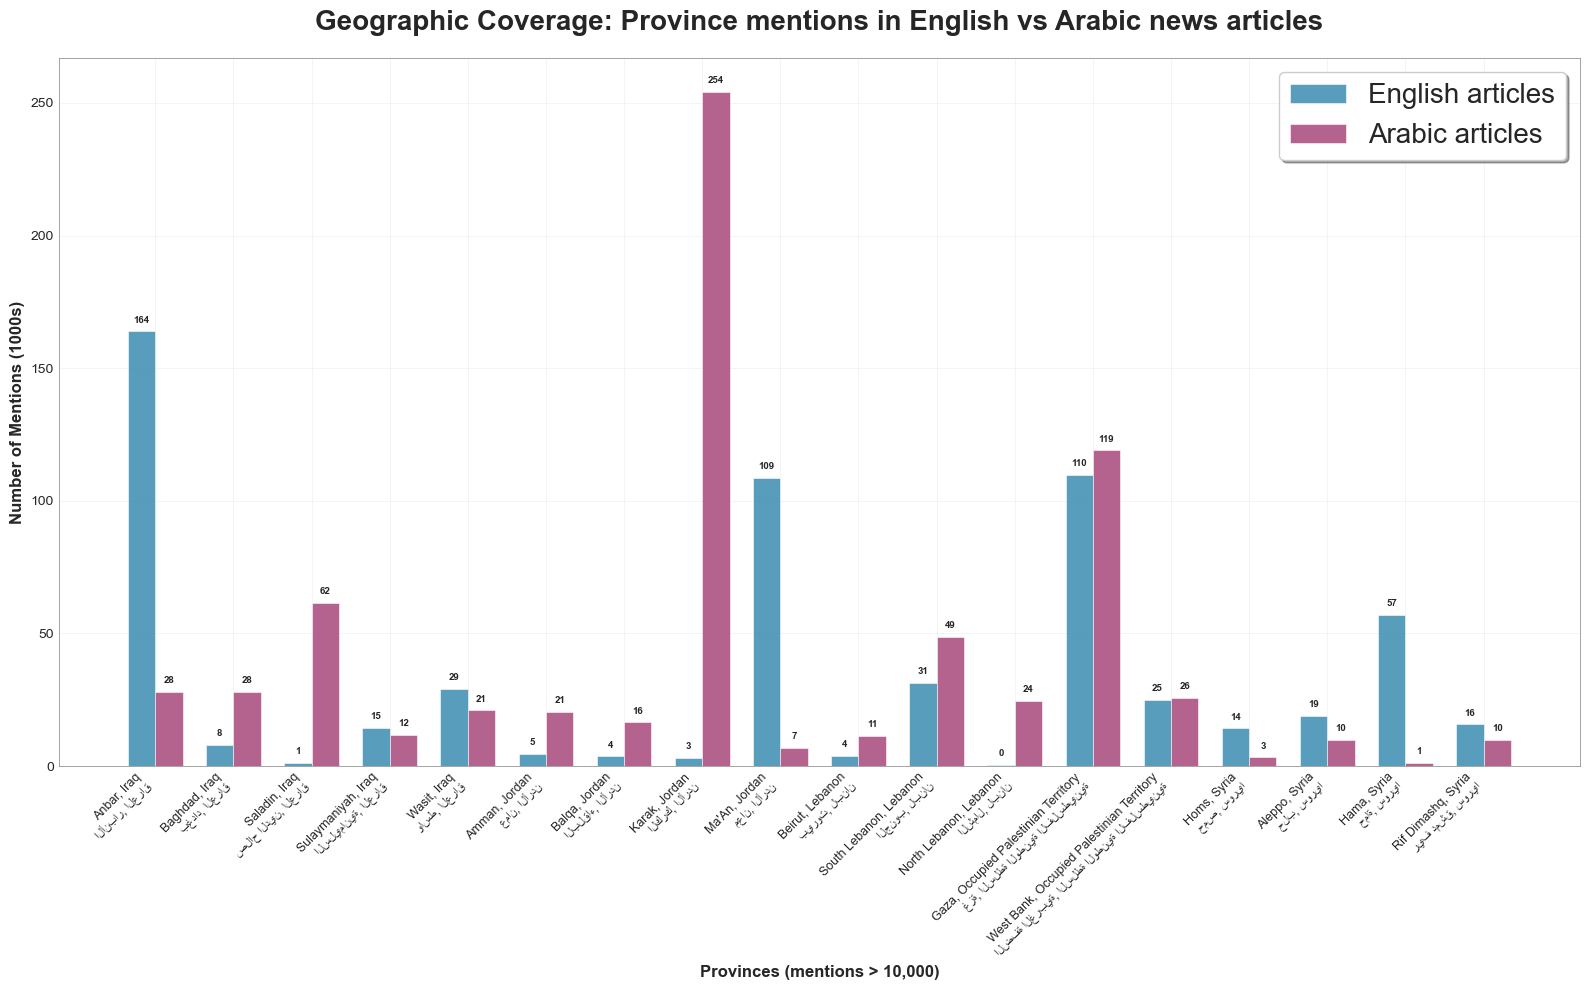

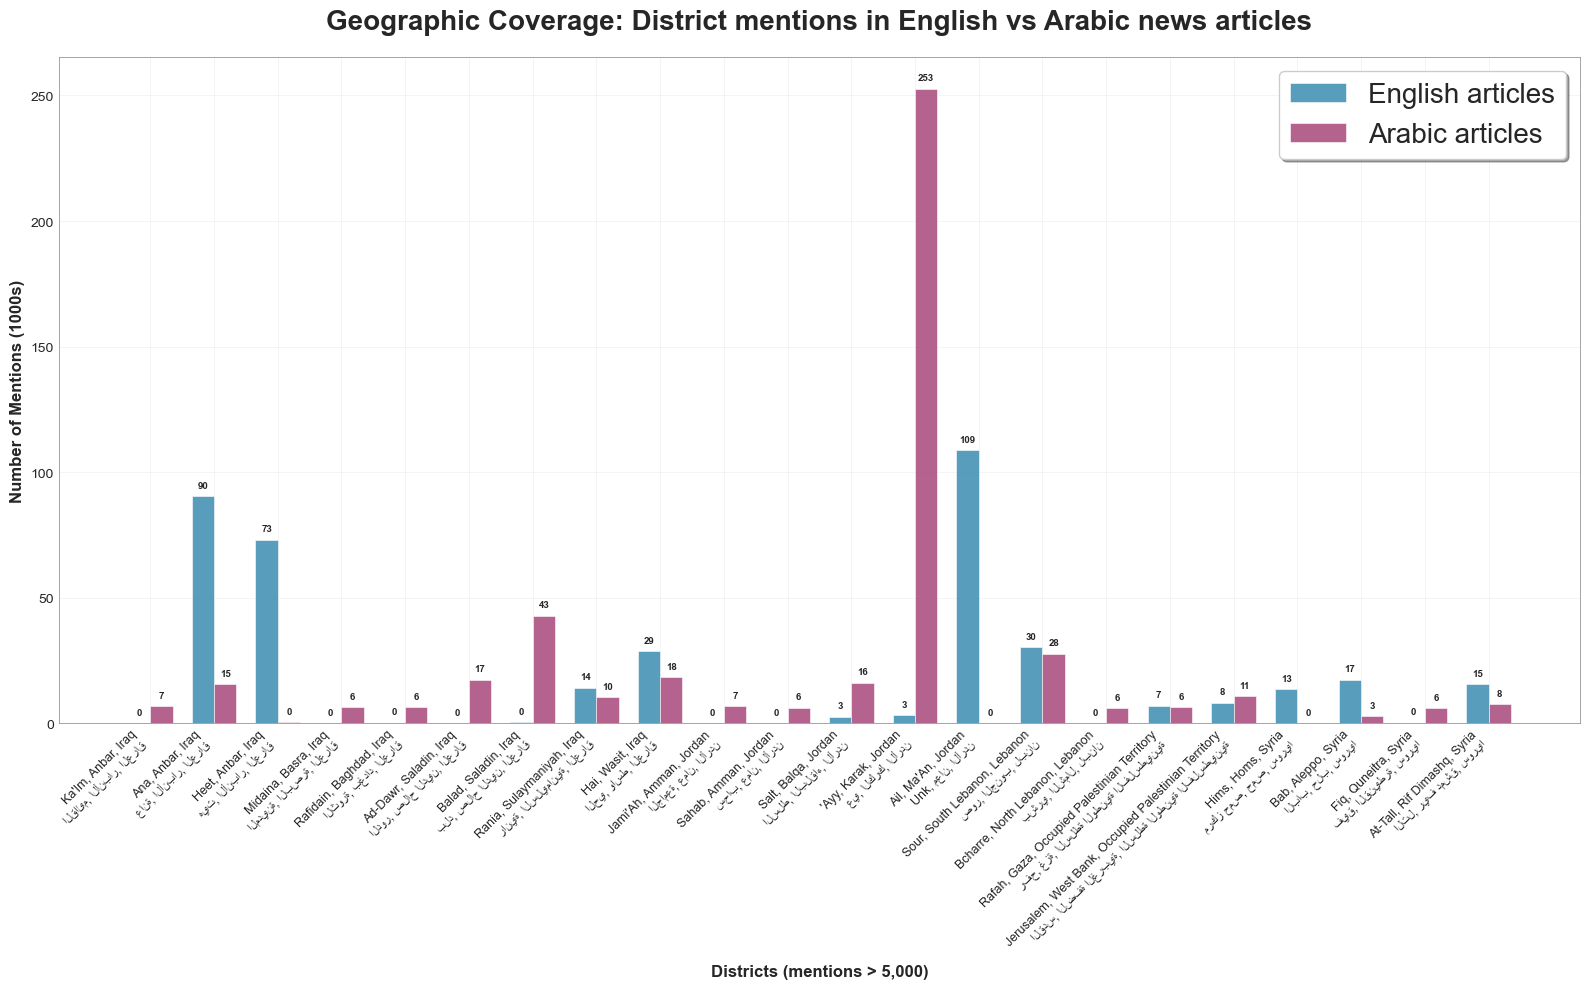

In [153]:
"""Visualize mention distributions in English and Arabic."""
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

def plot_shared_locations(
        location_mentions_df: pd.DataFrame,
        location_type: str = 'province',
        min_mentions: int = 5000,
        plot_in_units: int = 1000,
        add_value_labels_to_bars: bool = True,
        add_province_labels: bool = False,
        add_country_labels: bool = True
    ) -> plt.Figure:
    """Plot shared locations in English and Arabic news articles.
    
    Args:
        location_mentions_df: (pd.DataFrame) of location mentions and taxonomy.
        location_type: (str) type of location to plot.
        min_mentions: (int) minimum number of mentions to include.
        plot_in_units: (int) number of units to plot on the y-axis (e.g. 1000 for thousands).
        add_value_labels_to_bars: (bool) whether to add value labels to bars.
        add_province_labels: (bool) whether to add province labels to the item names.
        add_country_labels: (bool) whether to add country labels to the item names.
        
    Returns:
        plt: matplotlib plot of shared locations.
    """
    # Get location_type subset
    plot_data = location_mentions_df.loc[location_mentions_df['location_type'] == location_type].copy()

    # Apply minimum mentions threshold
    plot_data = plot_data[(plot_data['english_mentions'] >= min_mentions) | (plot_data['arabic_mentions'] >= min_mentions)]
    plot_data[['english_mentions', 'arabic_mentions']] = plot_data[['english_mentions', 'arabic_mentions']] / plot_in_units
    
    def format_names(row: pd.Series) -> str:
        assert isinstance(row[f'english_{location_type}_names'], list) and isinstance(row[f'arabic_{location_type}_names'], list)
        assert len(row[f'english_{location_type}_names']) > 0 and len(row[f'arabic_{location_type}_names']) > 0
        english_name = row[f'english_{location_type}_names'][0].title()
        arabic_name = row[f'arabic_{location_type}_names'][0].title()
        if add_province_labels:
            english_name += f", {english_taxonomy[row['geocode'][:5]][0].title()}"
            arabic_name += f", {arabic_taxonomy[row['geocode'][:5]][0].title()}"
        if add_country_labels:
            english_name += f", {english_taxonomy[row['geocode'][:2]][0].title()}"
            arabic_name += f", {arabic_taxonomy[row['geocode'][:2]][0].title()}"
        return f"{english_name}\n{arabic_name}"

    plot_data['label'] = plot_data.apply(format_names, axis=1)

    # Sort by country for easier pattern recognition
    plot_data.sort_values(by='geocode', inplace=True)

    # Create the plot
    x = np.arange(len(plot_data))
    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 10))
    fig.patch.set_facecolor('white')

    # Plot bars 
    bars1 = ax.bar(x - width/2, plot_data['english_mentions'], width, label='English articles', 
                alpha=0.8, color='#2E86AB', edgecolor='white', linewidth=0.5)
    bars2 = ax.bar(x + width/2, plot_data['arabic_mentions'], width, label='Arabic articles', 
                alpha=0.8, color='#A23B72', edgecolor='white', linewidth=0.5)

    # Customize the plot
    ax.set_xlabel(f'{location_type.title()}s (mentions > {min_mentions:,})', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Number of Mentions ({plot_in_units}s)', fontsize=12, fontweight='bold')
    ax.set_title(f'Geographic Coverage: {location_type.title()} mentions in English vs Arabic news articles', 
                fontsize=20, fontweight='bold', pad=20)

    # Set x-axis labels with rotation
    ax.set_xticks(x)
    ax.set_xticklabels(plot_data['label'], rotation=45, ha='right', fontsize=9)

    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Add legend
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=20)

    # Add value labels on bars 
    def add_value_labels(bars, counts):
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + max(plot_data['english_mentions'] + plot_data['arabic_mentions']) * 0.01,
                    round(count), ha='center', va='bottom', fontsize=7, fontweight='bold')

    if add_value_labels_to_bars:
        add_value_labels(bars1, plot_data['english_mentions'])
        add_value_labels(bars2, plot_data['arabic_mentions'])

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Add subtle border
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(0.5)

    # Save figure
    plt.savefig(os.path.join(RESULTS_DIR, f'shared_{location_type}_comparison.png'), 
        dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')

    return plt


RESULTS_DIR = './results'
province_plot = plot_shared_locations(
    location_mentions_df=location_df,
    location_type='province',
    min_mentions=10000
)
province_plot.show()


district_plot = plot_shared_locations(
    location_mentions_df=location_df,
    location_type='district',
    add_province_labels=True,
    min_mentions=5000
)
district_plot.show()


In [155]:
def get_mentions_ratio(row: pd.Series, col_name: str = 'mentions', one_zero_case: np.float64 = np.inf, min_mentions: int = 1000) -> np.float64:
    """Hacky way to handle quotients with possible zeros."""
    if row[f'english_{col_name}'] == row[f'arabic_{col_name}'] == 0:
        # If both are 0, return 0
        return 0
    elif row[f'english_{col_name}'] < min_mentions and row[f'arabic_{col_name}'] < min_mentions:
        # If both are below minimum mentions, return 0
        return 0
    elif row[f'english_{col_name}'] > row[f'arabic_{col_name}'] > 0:
        # If both positive and English has more mentions than Arabic, return the English/Arabic ratio
        return row[f'english_{col_name}'] / row[f'arabic_{col_name}']
    elif row[f'arabic_{col_name}'] > row[f'english_{col_name}'] > 0:
        # If both positive and Arabic has more mentions than English, return the Arabic/English ratio
        return row[f'arabic_{col_name}'] / row[f'english_{col_name}']
    else:
        # If one is 0 and the other is not, could count this as maximally different (or not)
        return one_zero_case

def print_joint_location_results(location_mentions_df: pd.DataFrame, location_type: str = 'province', top_n: int = 10):
    """Prints results of joint location analysis."""
    tmp_df = location_mentions_df.loc[location_mentions_df['location_type'] == location_type].copy()

    # Show top locations by total mentions
    print(f"\nTop {top_n} {location_type}s by total mentions across both languages:")
    tmp_df['total_mentions'] = tmp_df['english_mentions'] + tmp_df['arabic_mentions']
    count = 1
    # Printing just first name for each location
    for _, row in tmp_df.sort_values(by='total_mentions', ascending=False).head(top_n).iterrows():
        print(f"{count}. {row[f'english_{location_type}_names'][0].title()}, {row['english_country_names'][0].title()} ({row[f'arabic_{location_type}_names'][0].title()}, {row['arabic_country_names'][0].title()}): Total={row['total_mentions']:,} (Eng: {row['english_mentions']:,}, Ara: {row['arabic_mentions']:,})")
        count += 1

    # Show locations with largest differences
    print(f"\nTop {top_n} {location_type}s with largest differences in mentions across both languages:")
    tmp_df['ratio'] = tmp_df.apply(get_mentions_ratio, axis=1)
    count = 1
    for _, row in tmp_df.sort_values(by='ratio', ascending=False).head(top_n).iterrows():
        if row['english_mentions'] > row['arabic_mentions']:
            print(f"{count}. {row[f'english_{location_type}_names'][0].title()}, {row['english_country_names'][0].title()} ({row[f'arabic_{location_type}_names'][0].title()}, {row['arabic_country_names'][0].title()}): English={row['english_mentions']:,} >> Arabic={row['arabic_mentions']:,} (Ratio = {row['ratio']:.2f})")
        else:
            print(f"{count}. {row[f'english_{location_type}_names'][0].title()}, {row['english_country_names'][0].title()} ({row[f'arabic_{location_type}_names'][0].title()}, {row['arabic_country_names'][0].title()}): Arabic={row['arabic_mentions']:,} >> English={row['english_mentions']:,} (Ratio = {row['ratio']:.2f})")
        count += 1

print_joint_location_results(location_df, location_type='province')

print_joint_location_results(location_df, location_type='district')


Top 10 provinces by total mentions across both languages:
1. Karak, Jordan (الكرك, الأردن): Total=257,439 (Eng: 3,199, Ara: 254,240)
2. Gaza, Occupied Palestinian Territory (غزة, السلطة الوطنية الفلسطينية): Total=228,647 (Eng: 109,647, Ara: 119,000)
3. Anbar, Iraq (الأنبار, العراق): Total=191,820 (Eng: 163,858, Ara: 27,962)
4. Ma'An, Jordan (معان, الأردن): Total=115,498 (Eng: 108,758, Ara: 6,740)
5. South Lebanon, Lebanon (الجنوب, لبنان): Total=80,037 (Eng: 31,373, Ara: 48,664)
6. Saladin, Iraq (صلاح الدين, العراق): Total=62,701 (Eng: 1,067, Ara: 61,634)
7. Hama, Syria (حماة, سوريا): Total=58,176 (Eng: 56,902, Ara: 1,274)
8. West Bank, Occupied Palestinian Territory (الضفة الغربية, السلطة الوطنية الفلسطينية): Total=50,525 (Eng: 24,840, Ara: 25,685)
9. Wasit, Iraq (واسط, العراق): Total=50,186 (Eng: 29,170, Ara: 21,016)
10. Baghdad, Iraq (بغداد, العراق): Total=36,000 (Eng: 7,946, Ara: 28,054)

Top 10 provinces with largest differences in mentions across both languages:
1. Karak, Jordan 

It's clear that English- and Arabic-language news readers (or new publishers) care about different news, yet there is nothing remarkable from the above analysis. That being said, provinces of Hama, Syria and Ma'an, Jordan are exceptions in that there are significantly more English than Arabic news stories mentioning them. I would look into what is happening there (e.g., what political developments, assets, or other geopolitical significance) to draw Anglo attention.

Now let's take a look at the risk factors data we have:

In [160]:
"""Look for risk factors in articles."""

def analyze_risk_factors(
        articles: pd.Series, 
        risk_factors_df: pd.DataFrame, 
        language: str,
        use_findall: bool = False
    ) -> pd.DataFrame:
    """Analyze risk factor distribution in news coverage.
    Looks for mentions of risk factors (as defined in the given Excel data) in the news articles 'body'
    and counts them. 

    Note: I am using effectively the same code as above, going forward would refactor this to use as a single function 
    for both risk factors and locations.
    
    Args:
        articles: (pd.Series) of (str) news articles.
        risk_factors_df: (pd.DataFrame) of risk factors information.
        language: (str) language of the news articles and risk factors.
        use_findall: (bool) whether to use str.findall to find all matches for each location.
            (Tests indicate slightly faster for use_findall=False)

    Returns:
        risk_factors_enriched_df: (pd.DataFrame) of risk factors enriched with mentions and article indices.
    """
    assert articles.isna().sum() == 0, f"Empty articles present!"
    assert articles.dtype == "O", f"Articles dtype is {articles.dtype} but should be object"
    
    # Count matches by risk factor
    risk_factor_mentions = {}
    # Keep track of which articles mention each risk factor
    risk_factor_to_article_indices = {}

    risk_factors_enriched_df = risk_factors_df.copy()

    if use_findall:
        # Search single combined pattern for all factor using str.findall in one pass
        combined_pattern = '|'.join(re.escape(rf.lower()) for rf in risk_factors_df[f'risk_factor_{language}'])
        all_matches = articles.str.lower().str.findall(combined_pattern)
        assert all_matches.shape == (len(articles),), f"All matches shape is {all_matches.shape} but should be {(len(articles),)}"
        # Iterate over all matches for each article, recording indices
        for i, article_matches in all_matches.items():
            for risk_factor in article_matches:
                risk_factor_to_article_indices[risk_factor] = risk_factor_to_article_indices.get(risk_factor, []) + [i]
                risk_factor_mentions[risk_factor] = risk_factor_mentions.get(risk_factor, 0) + 1
    else:
        # Search each location individually using str.count
        for risk_factor in risk_factors_df[f'risk_factor_{language}']:
            # Count number of location matches across all texts
            article_counts = articles.str.lower().str.count(risk_factor)
            assert article_counts.dtype == "int64", f"Article counts dtype is {article_counts.dtype} but should be int64"
            risk_factor_to_article_indices[risk_factor] = article_counts[article_counts > 0].index.tolist()
            risk_factor_mentions[risk_factor] = risk_factor_mentions.get(risk_factor, 0) + article_counts.sum()

    risk_factors_enriched_df[f'risk_factor_mentions_{language}'] = risk_factors_enriched_df[f'risk_factor_{language}'].map(risk_factor_mentions)
    risk_factors_enriched_df[f'risk_factor_to_article_indices_{language}'] = risk_factors_enriched_df[f'risk_factor_{language}'].map(risk_factor_to_article_indices)
    return risk_factors_enriched_df


In [161]:
"""Analysis of risk factors."""

# Get new risk factors DataFrame that includes enriched columns
risk_factors_enriched = analyze_risk_factors(
    articles=news_articles_eng.body, 
    risk_factors_df=merged_risk_factors, 
    language='english'
)

# Enrich further with Arabic risk factors
risk_factors_enriched = analyze_risk_factors(
    articles=news_articles_ara.body, 
    risk_factors_df=risk_factors_enriched, 
    language='arabic'
)

In [162]:
assert len(risk_factors_enriched) == len(merged_risk_factors) == NUM_GIVEN_RISK_FACTORS

# Save risk factors enriched to CSV
risk_factors_enriched.to_csv(os.path.join(INTERMEDIATE_DIR, 'risk_factors_enriched.csv'), index=False)

risk_factors_enriched.head(10)

,risk_factor_english,risk_factor_arabic,cluster_english,cluster_arabic,risk_factor_mentions_english,risk_factor_to_article_indices_english,risk_factor_mentions_arabic,risk_factor_to_article_indices_arabic
0,lack of cultivation,نقص الزراعة,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
1,water distribution shortages,نقص توزيع المياه,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
2,disruption to farming,تعطيل الزراعة,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
3,failed crops,محاصيل فاشلة,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
4,transport bottleneck,اختناق النقل,agricultural production issues,قضايا الإنتاج الزراعي,1,[19400],0,[]
5,harvests are devastated,المحاصيل مدمرة,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
6,lack of agricultural infrastructure,نقص البنية التحتية الزراعية,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
7,harvest decline,انخفاض الحصاد,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
8,lack of roads,نقص الطرق,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
9,cattle death,موت الماشية,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]


Here, again, we use a keyword matching, but this has obviously limitations. In practice, we would prefer a `fuzzymatch`, traditional NLP, or a LLM-assisted analysis of the documents for these risk factors and clusters. Yet due to time and resource constraints (and potentially the lack of off-the-shelf Arabic NLP tools) here we are limited to a nice built-in, if limited, exact matching approach.

*Still, we can observe with this limited analysis some intuitive trends. For example, news media in both languages seems to produce (or get traction) in "sensational" articles like those relating to terrorism, conflict, and displacement. Indeed, "confict" is the number one mentioned risk factor (excluding "rise", which is much too ambiguous) across both languages.*

The multi-lingual benefits are pretty clear: we get broader, more robust coverage of regional news (i.e. reduced bias from English-only sources). In addition, we speculate that there would be cultural context and local/regional terminology in Arabic that would be missing in comparable English-language articles. As a result, analysis of both language media would be needed to capture what is happening and, ultimately, to build early warning predictors of risk (such as food insecurity). Of course, it would be beneficial to have team members with domain expertise (not just in Arabic language, but culture and media) who could provide input and feedback on analysis and metrics that rely on NLP and LLM assumptions and probabilities.

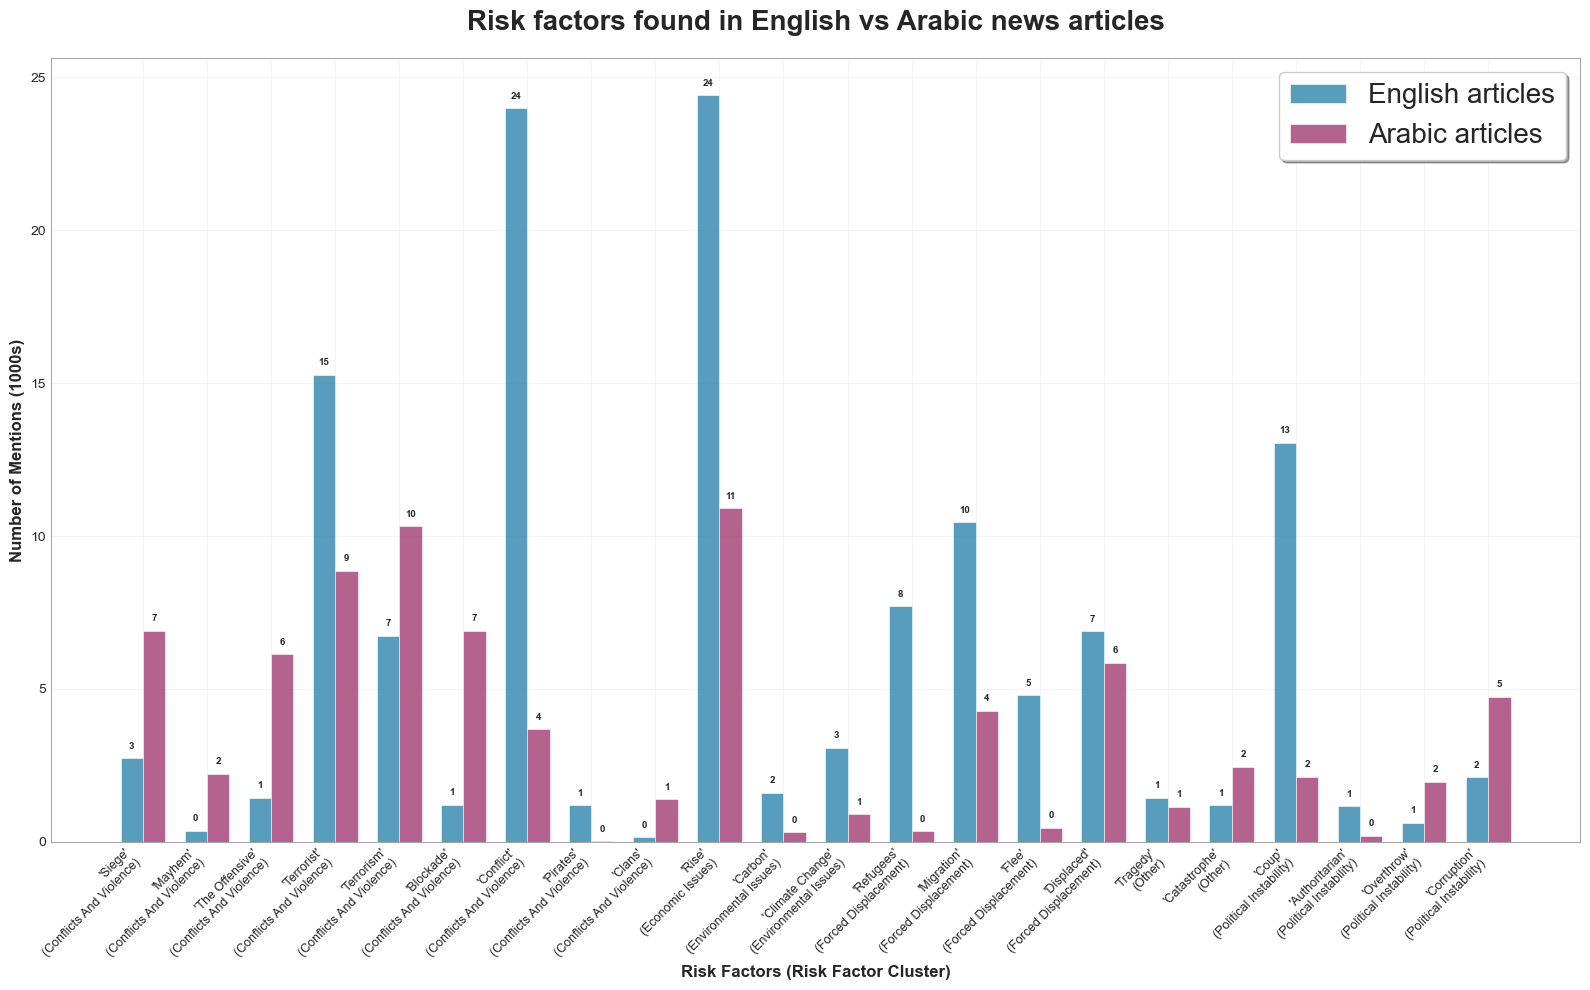

Total English-language articles with risk factors: 45323
Total Arabic-language articles with risk factors: 29785
Total English-language risk factor mentions: 142889
Total Arabic-language risk factor mentions: 91572
Total English-language risk factors mentioned: 116/167
Total Arabic-language risk factors mentioned: 97/167

Top 10 risk factors by total mentions across both languages:
1. "Rise" (Economic Issues): Total=35,326 (Eng: 24,410, Ara: 10,916)
2. "Conflict" (Conflicts And Violence): Total=27,661 (Eng: 23,986, Ara: 3,675)
3. "Terrorist" (Conflicts And Violence): Total=24,139 (Eng: 15,278, Ara: 8,861)
4. "Terrorism" (Conflicts And Violence): Total=17,052 (Eng: 6,734, Ara: 10,318)
5. "Coup" (Political Instability): Total=15,175 (Eng: 13,050, Ara: 2,125)
6. "Migration" (Forced Displacement): Total=14,738 (Eng: 10,444, Ara: 4,294)
7. "Displaced" (Forced Displacement): Total=12,745 (Eng: 6,893, Ara: 5,852)
8. "Siege" (Conflicts And Violence): Total=9,634 (Eng: 2,732, Ara: 6,902)
9. "Bl

In [164]:
def plot_shared_risk_factors(
        risk_factors_df: pd.DataFrame, 
        min_mentions: int = 5000,
        plot_in_units: int = 1000,
        add_value_labels_to_bars: bool = True,
    ):
    """Plot shared risk factors across English and Arabic news articles.
    
    Args:
        risk_factors_df: (pd.DataFrame) of risk factors enriched with mentions and article indices.
        plot_in_units: (int) number of units to plot on the y-axis (e.g. 1000 for thousands).
        min_mentions: (int) minimum number of mentions to include.
        add_value_labels_to_bars: (bool) whether to add value labels to bars.
        
    Returns:
        plt: (plt) matplotlib plot of shared risk factors.
    """
    # Sort by country for easier pattern recognition
    risk_factors_df.sort_values(by='cluster_english', inplace=True)

    # Create data arrays for plotting, applying minimum threshold
    eng_counts = []
    ara_counts = []
    labels = []
    for i, row in risk_factors_df.iterrows():
        if max(row['risk_factor_mentions_english'], row['risk_factor_mentions_arabic']) >= min_mentions:
            eng_counts.append(row['risk_factor_mentions_english'] / plot_in_units)
            ara_counts.append(row['risk_factor_mentions_arabic'] / plot_in_units)
            labels.append(f"'{row['risk_factor_english'].title()}'\n({row['cluster_english'].title()})")

    # Create the plot
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 10))
    fig.patch.set_facecolor('white')

    # Plot bars 
    bars1 = ax.bar(x - width/2, eng_counts, width, label='English articles', 
                alpha=0.8, color='#2E86AB', edgecolor='white', linewidth=0.5)
    bars2 = ax.bar(x + width/2, ara_counts, width, label='Arabic articles', 
                alpha=0.8, color='#A23B72', edgecolor='white', linewidth=0.5)

    # Customize the plot
    ax.set_xlabel('Risk Factors (Risk Factor Cluster)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Number of Mentions ({plot_in_units}s)', fontsize=12, fontweight='bold')
    ax.set_title(f'Risk factors found in English vs Arabic news articles', 
                fontsize=20, fontweight='bold', pad=20)

    # Set x-axis labels with rotation
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)

    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)

    # Add legend
    ax.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=20)

    # Add value labels on bars 
    def add_value_labels(bars, counts):
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + max(eng_counts + ara_counts) * 0.01,
                    round(count), ha='center', va='bottom', fontsize=7, fontweight='bold')

    if add_value_labels_to_bars:
        add_value_labels(bars1, eng_counts)
        add_value_labels(bars2, ara_counts)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Add subtle border
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(0.5)

    # Save as high-quality figure
    plt.savefig(os.path.join(RESULTS_DIR, 'shared_risk_factors_comparison.png'), 
        dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')

    return plt


def print_risk_factor_results(risk_factors_df, top_n: int = 10):
    assert len(risk_factors_df) == NUM_GIVEN_RISK_FACTORS  
    print(f"Total English-language articles with risk factors: {len(set([i for indices in risk_factors_df[f'risk_factor_to_article_indices_english'] for i in indices]))}")
    print(f"Total Arabic-language articles with risk factors: {len(set([i for indices in risk_factors_df[f'risk_factor_to_article_indices_arabic'] for i in indices]))}")
    print(f"Total English-language risk factor mentions: {sum(risk_factors_df[f'risk_factor_mentions_english'])}")
    print(f"Total Arabic-language risk factor mentions: {sum(risk_factors_df[f'risk_factor_mentions_arabic'])}")
    print(f"Total English-language risk factors mentioned: {risk_factors_df[f'risk_factor_mentions_english'].apply(lambda x: x > 0).sum()}/{len(risk_factors_df)}")
    print(f"Total Arabic-language risk factors mentioned: {risk_factors_df[f'risk_factor_mentions_arabic'].apply(lambda x: x > 0).sum()}/{len(risk_factors_df)}")
        
    tmp = risk_factors_df.copy()
    tmp['total_mentions'] = tmp['risk_factor_mentions_english'] + tmp['risk_factor_mentions_arabic']
    # Show top risk factors by total mentions across both languages (use English names for my own interpretability)
    print(f"\nTop {top_n} risk factors by total mentions across both languages:")
    count = 1
    for _, row in tmp.sort_values(by='total_mentions', ascending=False).head(top_n).iterrows():
        print(f'{count}. "{row["risk_factor_english"].title()}" ({row["cluster_english"].title()}): Total={row["total_mentions"]:,} (Eng: {row["risk_factor_mentions_english"]:,}, Ara: {row["risk_factor_mentions_arabic"]:,})')
        count += 1

    
    def get_mentions_ratio(row, one_zero_case: np.float64 = np.inf, min_mentions: int = 1000):
        """Hacky way to handle quotients with possible zeros."""
        if row['risk_factor_mentions_english'] == row['risk_factor_mentions_arabic'] == 0:
            return 0
        elif row['risk_factor_mentions_english'] < min_mentions and row['risk_factor_mentions_arabic'] < min_mentions:
            return 0
        elif row['risk_factor_mentions_english'] > row['risk_factor_mentions_arabic'] > 0:
            return row['risk_factor_mentions_english'] / row['risk_factor_mentions_arabic']
        elif row['risk_factor_mentions_arabic'] > row['risk_factor_mentions_english'] > 0:
            return row['risk_factor_mentions_arabic'] / row['risk_factor_mentions_english']
        else:
            # If one is 0 and the other is not, could count this as maximally (or not) different
            return one_zero_case

    # Find risk factors with "largest differences"
    tmp['mentions_ratio'] = tmp.apply(get_mentions_ratio, axis=1)
    print(f"\nTop {top_n} risk factors with largest differences in mentions across both languages:")
    count = 1
    for _, row in tmp.sort_values(by='mentions_ratio', ascending=False).head(top_n).iterrows():
        if row['risk_factor_mentions_english'] > row['risk_factor_mentions_arabic']:
            print(f'{count}. "{row["risk_factor_english"].title()}" ({row["cluster_english"].title()}): Eng={row["risk_factor_mentions_english"]:,} >> Ara={row["risk_factor_mentions_arabic"]:,} (Ratio={row["mentions_ratio"]:.2f})')
        else:
            assert row['risk_factor_mentions_english'] < row['risk_factor_mentions_arabic']
            print(f'{count}. "{row["risk_factor_english"].title()}" ({row["cluster_english"].title()}): Ara={row["risk_factor_mentions_arabic"]:,} >> Eng={row["risk_factor_mentions_english"]:,} (Ratio={row["mentions_ratio"]:.2f})')
        count += 1


risk_factors_plot = plot_shared_risk_factors(
    risk_factors_df=risk_factors_enriched,
    min_mentions=1000
)

risk_factors_plot.show()
print_risk_factor_results(risk_factors_enriched)

Looking at these results, I would again express frustration with "rise" being too ambiguous to appropriately use as much of an indicator (or even to appropriately classify it as an "economic issue"). Excluding "rise", however, we see a marked pattern of the remaining top 10 risk factors by mentions across both language news articles belonging to the risk factor families of "conflicts and violence" or "forced displacement" (actually, "coup" belongs to "political instability", but it could just as well be classified as "conflicts and violence").

**But the question remains, how can we use these signals to construct a food insecurity index (or predictor system)?**

As a baseline, let's create an composite risk score that (tries to) captures the intensity and diversity of risk factor mentions as well as intensity and diversity of geographic locations.

To that end, let's first recall what our locations data looks like:

In [167]:
location_df.head()

,geocode,location_type,english_district_names,arabic_district_names,english_province_names,arabic_province_names,english_country_names,arabic_country_names,english_mentions,arabic_mentions,english_indices,arabic_indices
0,lb_jl_2,district,[baabda],"[بعبدا, بعبدا‎]",[mount lebanon],[جبل لبنان],[lebanon],[لبنان],9,223,"[1900, 2258, 2730, 2768, 3526, 12352, 12630]","[64, 89, 100, 110, 117, 362, 581, 644, 921, 10..."
1,sy_qu_1,district,[fiq],[فيق],[quneitra],[القنيطرة],"[syria, syrian arab republic]",[سوريا],162,5924,"[7, 20, 129, 522, 685, 710, 892, 993, 1132, 11...","[14, 17, 23, 25, 36, 38, 47, 56, 57, 65, 68, 8..."
2,sy_hl_4,district,"[safira, safirah]",[السفيرة],[aleppo],[حلب],"[syria, syrian arab republic]",[سوريا],3,900,[9788],"[6, 49, 135, 138, 178, 212, 239, 422, 484, 595..."
3,jo_md_1,district,[UNK],[قصبة مادبا],[madaba],[مادبا],[jordan],[الأردن],0,0,[],[]
4,ps_gz_3,district,"[jabalya, north gaza]",[شمال غزة],[gaza],"[غزة, قطاع غزة]","[occupied palestinian territory, palestine, pa...","[السلطة الوطنية الفلسطينية, الضفة الغربية وقطا...",94,383,"[1095, 1209, 1245, 1246, 1247, 3730, 4136, 468...","[89, 195, 212, 222, 241, 1041, 2157, 2320, 255..."


Note that these {language}\_indices correspond to news_articles\_{language}.iloc[indices]

Importantly, these indices denote a match of the specific geocode (i.e. country OR province OR district); meaning if province "gaza" appears in article 10, index 10 will appear in the indices column for province geocode "ps_gz", but *NOT* in the indices for country geocode "ps" for Palestine. *This is different than the counts which are cumulative (so a country count includes province counts, etc.).*

And let's also take a look at the risk factors data:

In [166]:
"""And same with the risk factors data."""
risk_factors_enriched = pd.read_csv(os.path.join(INTERMEDIATE_DIR, 'risk_factors_enriched.csv'))

assert risk_factors_enriched.isna().sum().sum() == 0, f"risk_factors_enriched has {risk_factors_enriched.isna().sum().sum()} missing values"
risk_factors_enriched.index.name = 'risk_factor'
risk_factors_enriched = risk_factors_enriched.reset_index()
risk_factors_enriched.rename(columns={
    'risk_factor_to_article_indices_english': 'english_indices', 
    'risk_factor_to_article_indices_arabic': 'arabic_indices', 
    'risk_factor_mentions_english': 'english_mentions', 
    'risk_factor_mentions_arabic': 'arabic_mentions',
    'risk_factor_english': 'english_name',
    'risk_factor_arabic': 'arabic_name',
    'cluster_english': 'english_cluster',
    'cluster_arabic': 'arabic_cluster',
    }, 
    inplace=True
)
risk_factors_enriched.head(10)

,risk_factor,english_name,arabic_name,english_cluster,arabic_cluster,english_mentions,english_indices,arabic_mentions,arabic_indices
0,0,lack of cultivation,نقص الزراعة,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
1,1,water distribution shortages,نقص توزيع المياه,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
2,2,disruption to farming,تعطيل الزراعة,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
3,3,failed crops,محاصيل فاشلة,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
4,4,transport bottleneck,اختناق النقل,agricultural production issues,قضايا الإنتاج الزراعي,1,[19400],0,[]
5,5,harvests are devastated,المحاصيل مدمرة,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
6,6,lack of agricultural infrastructure,نقص البنية التحتية الزراعية,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
7,7,harvest decline,انخفاض الحصاد,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
8,8,lack of roads,نقص الطرق,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]
9,9,cattle death,موت الماشية,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[]


Now let's compare the location indices to the risk factor indices to gauge if there is risk factor-language associated with our locations of interest:

In [168]:
"""Let's get the intersection of risk factors and locations indices."""
rf_intersection_cols = {}

# For each geolocation, create a new column with intersecting article indices
for location_code in location_mentions_df['geocode']:
    # Get article indices for this location
    en_indices = location_mentions_df[location_mentions_df['geocode'] == location_code]['english_indices'].iloc[0]
    assert isinstance(en_indices, list), f"English indices are not a list: {en_indices}"
    ar_indices = location_mentions_df[location_mentions_df['geocode'] == location_code]['arabic_indices'].iloc[0]
    assert isinstance(ar_indices, list), f"Arabic indices are not a list: {ar_indices}"

    # Calculate intersection for each risk factor
    rf_intersection_cols[f'english_indices_{location_code}'] = risk_factors_enriched['english_indices'].apply(
        lambda risk_articles: list(set(risk_articles) & set(en_indices))
    )
    rf_intersection_cols[f'arabic_indices_{location_code}'] = risk_factors_enriched['arabic_indices'].apply(
        lambda risk_articles: list(set(risk_articles) & set(ar_indices))
    )

# Add all columns at once
intersection_df = pd.concat([risk_factors_enriched, pd.DataFrame(rf_intersection_cols)], axis=1)

intersection_df.head()

,risk_factor,english_name,arabic_name,english_cluster,arabic_cluster,english_mentions,english_indices,arabic_mentions,arabic_indices,english_indices_lb_jl_2,...,english_indices_iq_sl_17,arabic_indices_iq_sl_17,english_indices_ps,arabic_indices_ps,english_indices_iq_ts_1,arabic_indices_iq_ts_1,english_indices_sy_ha_2,arabic_indices_sy_ha_2,english_indices_iq_wa_3,arabic_indices_iq_wa_3
0,0,lack of cultivation,نقص الزراعة,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[],[],...,[],[],[],[],[],[],[],[],[],[]
1,1,water distribution shortages,نقص توزيع المياه,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[],[],...,[],[],[],[],[],[],[],[],[],[]
2,2,disruption to farming,تعطيل الزراعة,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[],[],...,[],[],[],[],[],[],[],[],[],[]
3,3,failed crops,محاصيل فاشلة,agricultural production issues,قضايا الإنتاج الزراعي,0,[],0,[],[],...,[],[],[],[],[],[],[],[],[],[]
4,4,transport bottleneck,اختناق النقل,agricultural production issues,قضايا الإنتاج الزراعي,1,[19400],0,[],[],...,[],[],[],[],[],[],[],[],[],[]


Going forward, I would likely make significant use of this intersected DataFrame, that gives me mention counts as well as well as mentioned article indices by location!

For now, let's try to create a composite insecurity "score":

In [170]:
"""Let's do some 'feature engineering' (effectively just summary statistics)."""
summary_stats = risk_factors_enriched[['english_name', 'english_cluster', 'english_mentions', 'arabic_mentions']].copy()
summary_stats['english_num_articles'] = risk_factors_enriched['english_indices'].apply(len)
summary_stats['arabic_num_articles'] = risk_factors_enriched['arabic_indices'].apply(len)

en_district_cols = [col for col in intersection_df.columns if col.startswith('english_indices_') and len(col.split('_')) == 5]
ar_district_cols = [col for col in intersection_df.columns if col.startswith('arabic_indices_') and len(col.split('_')) == 5]

# Number of unique districts that are mentioned together with given risk factor
summary_stats['english_num_districts'] = intersection_df[en_district_cols].apply(
    lambda row: sum(1 for articles in row if len(articles) > 0), axis=1
)
summary_stats['arabic_num_districts'] = intersection_df[ar_district_cols].apply(
    lambda row: sum(1 for articles in row if len(articles) > 0), axis=1
)

en_province_cols = [col for col in intersection_df.columns if col.startswith('english_indices_') and len(col.split('_')) == 4]
ar_province_cols = [col for col in intersection_df.columns if col.startswith('arabic_indices_') and len(col.split('_')) == 4]

# Number of unique provinces that are mentioned together with given risk factor
summary_stats['english_num_provinces'] = intersection_df[en_province_cols].apply(
    lambda row: sum(1 for articles in row if len(articles) > 0), axis=1
)
summary_stats['arabic_num_provinces'] = intersection_df[ar_province_cols].apply(
    lambda row: sum(1 for articles in row if len(articles) > 0), axis=1
)

en_country_cols = [col for col in intersection_df.columns if col.startswith('english_indices_') and len(col.split('_')) == 3]
ar_country_cols = [col for col in intersection_df.columns if col.startswith('arabic_indices_') and len(col.split('_')) == 3]

# Number of unique countries that are mentioned together with given risk factor
summary_stats['english_num_countries'] = intersection_df[en_country_cols].apply(
    lambda row: sum(1 for articles in row if len(articles) > 0), axis=1
)
summary_stats['arabic_num_countries'] = intersection_df[ar_country_cols].apply(
    lambda row: sum(1 for articles in row if len(articles) > 0), axis=1
)

# Specific locations with most intersections
summary_stats['english_country_max_articles'] = intersection_df[en_country_cols].apply(
    lambda row: max(len(articles) for articles in row), axis=1 
)
summary_stats['english_country_max_name'] = intersection_df[en_country_cols].apply(
    lambda row: english_taxonomy[en_country_cols[np.argmax([len(articles) for articles in row])][-2:]][0].title(), axis=1
)
summary_stats['arabic_country_max_articles'] = intersection_df[ar_country_cols].apply(
    lambda row: max(len(articles) for articles in row), axis=1
)
summary_stats['arabic_country_max_name'] = intersection_df[ar_country_cols].apply(
    lambda row: arabic_taxonomy[ar_country_cols[np.argmax([len(articles) for articles in row])][-2:]][0].title(), axis=1
)
summary_stats['english_province_max_articles'] = intersection_df[en_province_cols].apply(
    lambda row: max(len(articles) for articles in row), axis=1
)
summary_stats['english_province_max_name'] = intersection_df[en_province_cols].apply(
    lambda row: english_taxonomy[en_province_cols[np.argmax([len(articles) for articles in row])][-5:]][0].title(), axis=1
)
summary_stats['arabic_province_max_articles'] = intersection_df[ar_province_cols].apply(
    lambda row: max(len(articles) for articles in row), axis=1
)
summary_stats['arabic_province_max_name'] = intersection_df[ar_province_cols].apply(
    lambda row: arabic_taxonomy[ar_province_cols[np.argmax([len(articles) for articles in row])][-5:]][0].title(), axis=1
)
summary_stats['english_district_max_articles'] = intersection_df[en_district_cols].apply(
    lambda row: max(len(articles) for articles in row), axis=1
)
summary_stats['english_district_max_name'] = intersection_df[en_district_cols].apply(
    lambda row: english_taxonomy['_'.join(en_district_cols[np.argmax([len(articles) for articles in row])].split('_')[-3:])][0].title(), axis=1
)
summary_stats['arabic_district_max_articles'] = intersection_df[ar_district_cols].apply(
    lambda row: max(len(articles) for articles in row), axis=1
)
summary_stats['arabic_district_max_name'] = intersection_df[ar_district_cols].apply(
    lambda row: arabic_taxonomy['_'.join(ar_district_cols[np.argmax([len(articles) for articles in row])].split('_')[-3:])][0].title(), axis=1
)

custom_info(summary_stats)
summary_stats.sort_values(by='english_cluster').head(150)

Inspecting given DataFrame (167 rows, 24 columns):
Column                        	Data Type           	Missing Values      	Unique Values
----------------------------------------------------------------------------------------------------
english_name                  	str                 	0                   	NA        
english_cluster               	str                 	0                   	NA        
english_mentions              	int64               	0                   	86        
arabic_mentions               	int64               	0                   	68        
english_num_articles          	int64               	0                   	101       
arabic_num_articles           	int64               	0                   	81        
english_num_districts         	int64               	0                   	1         
arabic_num_districts          	int64               	0                   	1         
english_num_provinces         	int64               	0                   	1         
arabi

,english_name,english_cluster,english_mentions,arabic_mentions,english_num_articles,arabic_num_articles,english_num_districts,arabic_num_districts,english_num_provinces,arabic_num_provinces,...,arabic_country_max_articles,arabic_country_max_name,english_province_max_articles,english_province_max_name,arabic_province_max_articles,arabic_province_max_name,english_district_max_articles,english_district_max_name,arabic_district_max_articles,arabic_district_max_name
0,lack of cultivation,agricultural production issues,0,0,2,2,0,0,0,0,...,0,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا
14,unable to sow,agricultural production issues,0,0,2,2,0,0,0,0,...,0,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا
13,bad harvests,agricultural production issues,0,0,2,2,0,0,0,0,...,0,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا
12,livestock had died,agricultural production issues,0,0,2,2,0,0,0,0,...,0,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا
11,toll on livestock,agricultural production issues,0,0,2,2,0,0,0,0,...,0,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,totalitarian,political instability,210,340,1064,2044,0,0,0,0,...,0,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا
139,oppressive regimes,political instability,14,14,96,82,0,0,0,0,...,0,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا
138,authoritarian,political instability,1168,198,5897,783,0,0,0,0,...,0,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا
137,politically engineered,political instability,0,1,2,3,0,0,0,0,...,0,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا


Now we can begin to see more insights and how we might develop a predictive framework. Granted, I have engineered a few low-hanging features (i.e. how many unique provinces are mentioned with each risk factor, how many total mentions, etc.), but the imposed structure (at least for me) simplifies and grounds the otherwise very abstract task we have. 

In [ ]:
"""Vague outline for future grouped analysis of risk factors.

Going forward, I would also look at the results of articles 
that contain risk factors, grouped by individual risk factor, 
risk factor cluster, eventUri, authors, source, day and month.

Though I will skip this for now.
"""
news_articles_eng['day'] = news_articles_eng['datetime'].dt.day
news_articles_eng['month'] = news_articles_eng['datetime'].dt.month
news_articles_ara['day'] = news_articles_ara['datetime'].dt.day
news_articles_ara['month'] = news_articles_ara['datetime'].dt.month

for df in [news_articles_eng, news_articles_ara]:
    for group in ['eventUri', 'authors', 'source', 'day', 'month']:
        grouped = df.groupby(group)
        # TODO: Look at risk factors in these groups

Ok, let's actually create the composite risk score:

In [171]:
"""Now let's create a (placeholder) composite risk score."""

def calculate_composite_risk_score(features: np.ndarray, weights: np.ndarray = None) -> np.ndarray:
    """Calculate a composite risk score.
    
    Args:
        features: array-like of shape (n_risk_factors, m_features)
        weights: array-like of shape (m_features,)

    Returns:
        scores: array-like of shape (n_risk_factors,)
    """
    if weights is None or len(weights) != features.shape[1]:
        weights = np.ones(features.shape[1])
    scores = np.dot(features, weights)
    return scores

features = pd.DataFrame({
    # Normalize by total number of words in articles
    'arabic_mentions': summary_stats['arabic_mentions'] / news_articles_ara.body.str.split().str.len().sum(),
    'english_mentions': summary_stats['english_mentions'] / news_articles_eng.body.str.split().str.len().sum(),
    # Normalize by total number of articles
    'english_num_articles': summary_stats['english_num_articles'] / len(news_articles_eng),
    'english_country_max_articles': summary_stats['english_country_max_articles'] / len(news_articles_eng),
    'english_province_max_articles': summary_stats['english_province_max_articles'] / len(news_articles_eng),
    'english_district_max_articles': summary_stats['english_district_max_articles'] / len(news_articles_eng),
    'arabic_num_articles': summary_stats['arabic_num_articles'] / len(news_articles_ara),
    'arabic_country_max_articles': summary_stats['arabic_country_max_articles'] / len(news_articles_ara),
    'arabic_province_max_articles': summary_stats['arabic_province_max_articles'] / len(news_articles_ara),
    'arabic_district_max_articles': summary_stats['arabic_district_max_articles'] / len(news_articles_ara),
    # Normalize by total number of countries
    'english_num_countries': summary_stats['english_num_countries'] / len([key for key in english_taxonomy if len(key) == 2]),
    'arabic_num_countries': summary_stats['arabic_num_countries'] / len([key for key in arabic_taxonomy if len(key) == 2]),
    # Normalize by total number of provinces
    'english_num_provinces': summary_stats['english_num_provinces'] / len([key for key in english_taxonomy if len(key) == 5]),
    'arabic_num_provinces': summary_stats['arabic_num_provinces'] / len([key for key in arabic_taxonomy if len(key) == 5]),
    # Normalize by total number of districts
    'english_num_districts': summary_stats['english_num_districts'] / len([key for key in english_taxonomy if len(key) > 5]),
    'arabic_num_districts': summary_stats['arabic_num_districts'] / len([key for key in arabic_taxonomy if len(key) > 5]),
})

risk_score = calculate_composite_risk_score(features)
summary_stats['risk_score'] = risk_score
summary_stats.sort_values(by='risk_score', ascending=False).head(50)

,english_name,english_cluster,english_mentions,arabic_mentions,english_num_articles,arabic_num_articles,english_num_districts,arabic_num_districts,english_num_provinces,arabic_num_provinces,...,arabic_country_max_name,english_province_max_articles,english_province_max_name,arabic_province_max_articles,arabic_province_max_name,english_district_max_articles,english_district_max_name,arabic_district_max_articles,arabic_district_max_name,risk_score
54,rise,economic issues,24410,10916,112942,42181,0,0,0,0,...,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا,1.797290
34,conflict,conflicts and violence,23986,3675,84130,16489,0,0,0,0,...,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا,1.164119
30,terrorist,conflicts and violence,15278,8861,45254,29598,0,0,0,0,...,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا,0.868858
136,coup,political instability,13050,2125,54794,8097,0,0,0,0,...,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا,0.727244
19,terrorism,conflicts and violence,6734,10318,23037,35014,0,0,0,0,...,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا,0.675745
91,displaced,forced displacement,6893,5852,28299,21700,0,0,0,0,...,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا,0.580619
88,migration,forced displacement,10444,4294,34489,14171,0,0,0,0,...,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا,0.564003
16,the offensive,conflicts and violence,1444,6134,7469,27256,0,0,0,0,...,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا,0.405156
21,siege,conflicts and violence,2732,6902,13856,17390,0,0,0,0,...,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا,0.363526
143,corruption,political instability,2106,4743,10157,16569,0,0,0,0,...,الأردن,0,Irbed,0,إربد,0,Baabda,0,بعبدا,0.311159


Let's take a look at some metrics from this "risk score":

In [172]:
print(f"Risk score metrics:")
print(f" - Risk score range: {risk_score.min():.3f} - {risk_score.max():.3f}")
print(f" - Mean risk score: {risk_score.mean():.3f}")
print(f" - Median risk score: {np.median(risk_score):.3f}")
print(f" - Current high-risk factors (z-score > 1): {np.sum(risk_score > risk_score.mean() + risk_score.std())}")
print(f" - Current very high-risk factors (z-score > 2): {np.sum(risk_score > risk_score.mean() + 2*risk_score.std())}")

# Very high risk factors:
print(f"\nVery high risk factors:")
summary_stats[['english_name', 'english_cluster', 'risk_score']][summary_stats['risk_score'] > risk_score.mean() + 2*risk_score.std()].sort_values(by='risk_score', ascending=False)

Risk score metrics:
 - Risk score range: 0.000 - 1.797
 - Mean risk score: 0.064
 - Median risk score: 0.002
 - Current high-risk factors (z-score > 1): 13
 - Current very high-risk factors (z-score > 2): 7

Very high risk factors:


,english_name,english_cluster,risk_score
54,rise,economic issues,1.797290
34,conflict,conflicts and violence,1.164119
30,terrorist,conflicts and violence,0.868858
136,coup,political instability,0.727244
19,terrorism,conflicts and violence,0.675745
91,displaced,forced displacement,0.580619
88,migration,forced displacement,0.564003


And---despite already seeing it's not doing much---let's visualize:

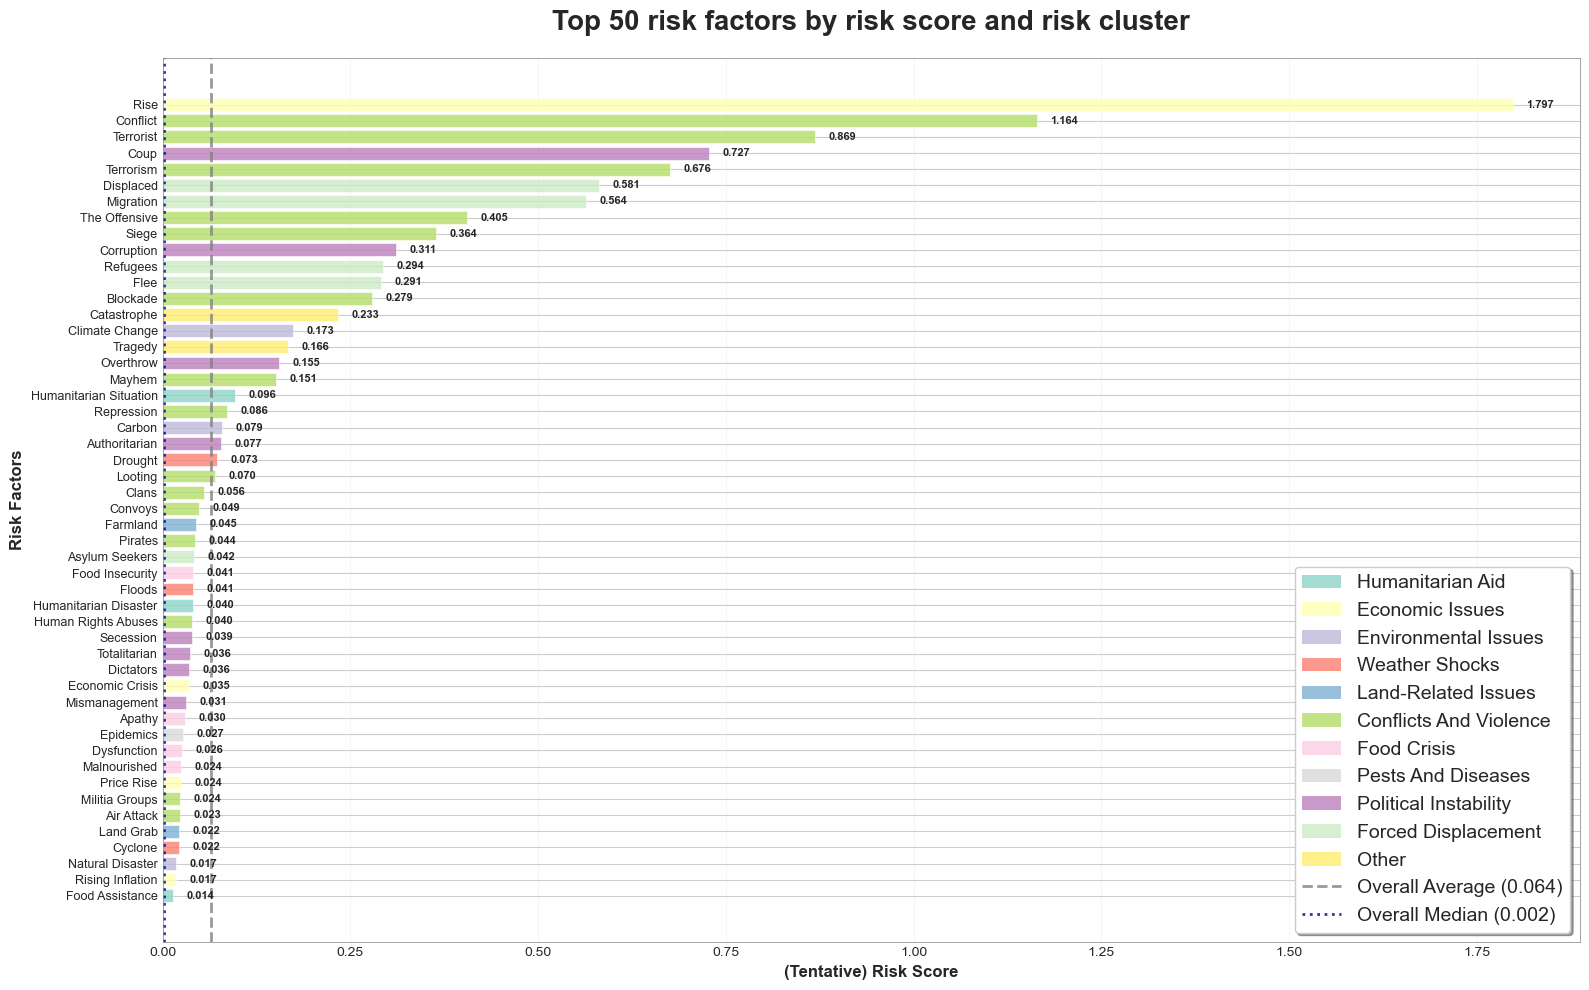

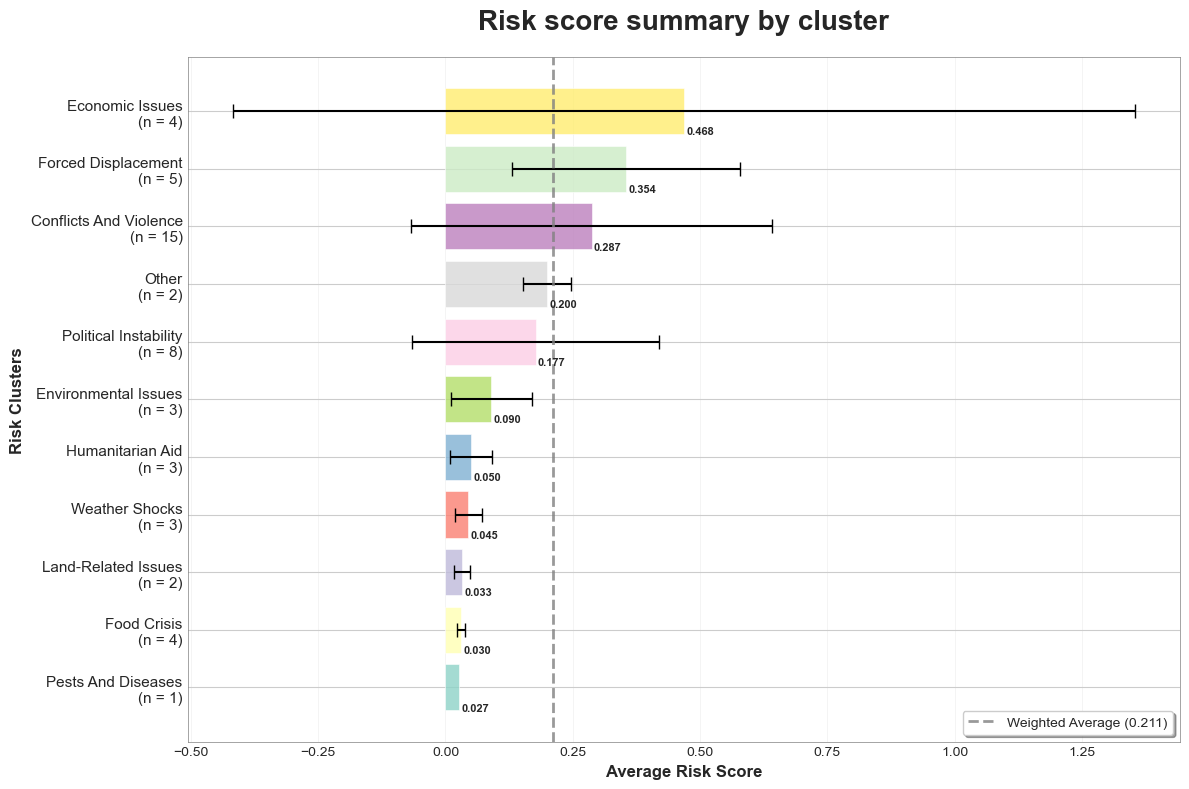

In [175]:
"""Look at risk scores."""

def plot_risk_scores(summary_stats: pd.DataFrame, top_n: int = 50):
    """Plot risk scores."""
    fig, ax = plt.subplots(figsize=(16, 10))
    fig.patch.set_facecolor('white')

    # Sort by risk score for better visualization
    plot_data = summary_stats[['english_name', 'english_cluster', 'risk_score']].sort_values(
        by='risk_score', ascending=False).head(top_n).sort_values(
            by='risk_score', ascending=True)

    # Create color mapping for clusters
    unique_clusters = plot_data['english_cluster'].unique()
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))
    cluster_colors = dict(zip(unique_clusters, colors))

    # Create the bar plot
    bars = ax.barh(range(len(plot_data)), plot_data['risk_score'], 
                color=[cluster_colors[cluster] for cluster in plot_data['english_cluster']],
                alpha=0.8, edgecolor='white', linewidth=0.5)

    # Add vertical line for average risk score across ALL risk factors
    overall_avg_risk = summary_stats['risk_score'].mean()
    ax.axvline(x=overall_avg_risk, color='grey', linestyle='--', linewidth=2, alpha=0.8, 
               label=f'Overall Average ({overall_avg_risk:.3f})')

    # Add overall median vertical line (calculated from original data)
    overall_median = summary_stats['risk_score'].median()
    ax.axvline(x=overall_median, color='darkblue', linestyle=':', linewidth=2, alpha=0.8, 
            label=f'Overall Median ({overall_median:.3f})')


    # Customize the plot
    ax.set_xlabel('(Tentative) Risk Score', fontsize=12, fontweight='bold')
    ax.set_ylabel('Risk Factors', fontsize=12, fontweight='bold')
    ax.set_title(f'Top {top_n} risk factors by risk score and risk cluster', 
                fontsize=20, fontweight='bold', pad=20)

    # Set y-axis labels
    ax.set_yticks(range(len(plot_data)))
    ax.set_yticklabels([rf.title() for rf in plot_data['english_name']], fontsize=9)

    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, axis='x')
    ax.set_axisbelow(True)

    # Create legend for clusters
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=cluster_colors[cluster], alpha=0.8, label=cluster.title()) 
                    for cluster in unique_clusters]
    # Add the average/median lines to legend
    legend_elements.append(plt.Line2D([0], [0], color='grey', linestyle='--', linewidth=2, alpha=0.8, 
                                     label=f'Overall Average ({overall_avg_risk:.3f})'))
    legend_elements.append(plt.Line2D([0], [0], color='darkblue', linestyle=':', linewidth=2, alpha=0.8,
                                     label=f'Overall Median ({overall_median:.3f})'))
    ax.legend(handles=legend_elements, loc='lower right', frameon=True, fancybox=True, shadow=True, fontsize=14)

    # Add value labels on bars 
    for i, (bar, score) in enumerate(zip(bars, plot_data['risk_score'])):
        width = bar.get_width()
        ax.text(width + max(plot_data['risk_score']) * 0.01, bar.get_y() + bar.get_height()/2,
            f'{score:.3f}', ha='left', va='center', fontsize=8, fontweight='bold')

    # Adjust layout
    plt.tight_layout()

    # Add subtle border
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(0.5)

    # Save as high-quality figure
    plt.savefig(os.path.join(RESULTS_DIR, 'risk_scores_by_factor.png'), dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')

    return plt, plot_data


def plot_cluster_summary(risk_scores_data: pd.DataFrame):
    """Plot cluster summary with error bars and count labels."""

    # Risk score summary by cluster
    cluster_summary = risk_scores_data.rename(
            columns={'english_cluster': 'Risk Cluster'}
        ).groupby('Risk Cluster').agg(
            {'risk_score': ['count', 'mean', 'std']}
        ).round(3)
    cluster_summary.columns = ['Count', 'Avg_Risk', 'Std_Risk']

    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('white')
    
    # Sort by average risk for better visualization
    plot_data = cluster_summary.sort_values(by='Avg_Risk', ascending=True)
    
    # Create color mapping
    colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))
    
    # Create the bar plot with error bars
    bars = ax.barh(range(len(plot_data)), plot_data['Avg_Risk'], 
                   xerr=plot_data['Std_Risk'], 
                   color=colors, alpha=0.8, edgecolor='white', linewidth=0.5,
                   capsize=5)
    
    # Customize the plot
    ax.set_xlabel('Average Risk Score', fontsize=12, fontweight='bold')
    ax.set_ylabel('Risk Clusters', fontsize=12, fontweight='bold')
    ax.set_title('Risk score summary by cluster', 
                fontsize=20, fontweight='bold', pad=20)
    
    # Set y-axis labels
    ax.set_yticks(range(len(plot_data)))
    ax.set_yticklabels([f"{cluster.title()}\n(n = {count})" for cluster, count in zip(plot_data.index, plot_data['Count'])], fontsize=11)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, axis='x')
    ax.set_axisbelow(True)
    
    # Add value labels for average risk scores
    for i, (bar, avg_risk) in enumerate(zip(bars, plot_data['Avg_Risk'])):
        width = bar.get_width()
        ax.text(width + max(plot_data['Avg_Risk']) * 0.01, bar.get_y() + bar.get_height()/2 - 0.35,
               f'{avg_risk:.3f}', ha='left', va='center', fontsize=8, fontweight='bold')
    
    # Add vertical line for average weighted risk score
    weighted_avg = (plot_data['Avg_Risk'] * plot_data['Count']).sum() / plot_data['Count'].sum()
    ax.axvline(x=weighted_avg, color='grey', linestyle='--', linewidth=2, alpha=0.8, 
               label=f'Weighted Average ({weighted_avg:.3f})')
    # Add legend to show the weighted average line
    ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True, fontsize=10)
    
    # Adjust layout
    plt.tight_layout()
    
    # Add subtle border
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(0.5)
    
    # Save as high-quality figure
    plt.savefig(os.path.join(RESULTS_DIR, 'cluster_summary.png'), dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    
    return plt, plot_data



# Create risk scores plot
risk_scores_plot, risk_scores_data = plot_risk_scores(summary_stats)
risk_scores_plot.show()

# Create the cluster summary plot
cluster_plot, cluster_plot_data = plot_cluster_summary(risk_scores_data)
cluster_plot.show()

While in theory we are looking for something to allow us to bypass--hopefully in an unbiased manner--the lack of ground truth food insecurity data, we see that (at least here, as of now) we are effectively just ranking risk factors by keyword occurence counts across articles. For the purposes of this analysis, I will not be going forward with any predictive modelling. In the future, we would spend more time developing a better index. And hopefully be able to use this framework to monitor the situation in "real-time" and train a model to predict future food insecurity events by incorporating time parameters so as to consider, e.g. articles weekly or monthly rather than the full set of articles given, and thereby ascertain temporal trends.

But for now, let's see if we can implement some *unsupervised* ML:

We use latent Dirichlet allocation (LDA) to model the semantic content of each article in order to then distinguish articles based on their topic relevance. Specifically, we can formalize our problem as one of unsupervised machine learning topic discovery (across all text) and subsequent labelling of each article according to the discovered topics. Intuitively, we can think of a topic here as a set of words that suggest a shared theme. Thus, we want discover $K$ topics such that words in topic $t_i$ are article-related, while words in all other topics $t_{j,1≤j≤K,j \neq i}$ are not. In fact, the number of topics $K$ is a hyper-parameter we will choose according to log-perplexity or coherence as a metric for topic coherence. Then, we can estimate the probability that each article is topic-related according to the distribution of that article across all topics. The first step in implementing this strategy is to process our textual data. We turn to lowercase all of our words, remove punctuation, and remove words not in a (standard) English dictionary before applying standard natural language processing (NLP) pre-processing (i.e. tokenization, filtering of stop-words, and stemming) to prepare our text for the subsequent vectorization. Next we vectorize our text data, leveraging Pythons gensim doc2bow fuctionality to convert a collection of words to its bag-of-words representation. Then, we can apply gensim's off-the-shelf LDA topic modelling, saving models that extract between $K = 2$ to $K = 20$ topics and calculating each model's "fit" according to the aforementioned log-perplexity, or how well words in a held-out set of articles fit each topic. 
Additionally, we can observe the highest-scored words by topic to manually validate our topic choice.

Finally, we can run our articles (i.e. text data) through our model to retrieve the probability distribution of each article over our discovered topics. We use three heuristics to then filter according to the recovered distribution: 1) retain articles with a non-zero probability mass on the
identified risk-factor-related topic/s; 2) retain articles with probability mass greater or equal to the mean (across all topics) on said topics; and 3) retain articles with the greatest probability mass on said topics. 

In [178]:
import gensim
from gensim import corpora
from gensim.models import LdaModel, Phrases, CoherenceModel
from gensim.models.phrases import Phraser
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
import nltk
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('wordnet')

def preprocess_text(text: str) -> list[str]:
    """Simple text preprocessing LDA topic modeling."""
    assert not pd.isna(text), "Text is NaN"
    
    # Convert to lowercase and remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
    
    # Tokenize and remove stopwords
    tokens = simple_preprocess(text, deacc=True, min_len=3, max_len=15)
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in STOPWORDS]
    
    return tokens

def lemmatize_tokens(tokens: list[str], lemmatizer: WordNetLemmatizer) -> list[str]:
    """Lemmatize tokens."""
    return [lemmatizer.lemmatize(token) for token in tokens]

def create_bigrams_trigrams(texts: list[str]) -> tuple[Phraser, Phraser]:
    """Create bigrams and trigrams."""
    bigram = Phrases(texts, min_count=5, threshold=100)
    trigram = Phrases(bigram[texts], threshold=100)
    return Phraser(bigram), Phraser(trigram)

def evaluate_lda_model(
        lda_model: LdaModel, 
        corpus: list[list[tuple[int, float]]], 
        dictionary: corpora.Dictionary, 
        texts: list[list[str]], 
        num_topics: int
    ) -> tuple[float, float]:
    """Evaluate LDA model using perplexity and coherence."""
    # Calculate perplexity
    perplexity = lda_model.log_perplexity(corpus)
    
    # Calculate coherence
    coherence_model = CoherenceModel(
        model=lda_model, 
        texts=texts, 
        dictionary=dictionary, 
        coherence='c_v'
    )
    coherence = coherence_model.get_coherence()
    
    return perplexity, coherence

def find_optimal_topics(
        corpus: list[list[tuple[int, float]]], 
        dictionary: corpora.Dictionary, 
        texts: list[list[str]], 
        min_topics: int = 2, 
        max_topics: int = 20
    ) -> tuple[range, list[float], list[float]]:
    """Find optimal number of topics using perplexity and coherence."""
    perplexities = []
    coherences = []
    topic_range = range(min_topics, max_topics + 1)
    
    print("Evaluating LDA models with different numbers of topics...")
    for num_topics in topic_range:
        print(f"Testing {num_topics} topics...")
        # Train LDA model
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            passes=10,
            alpha='auto',
            per_word_topics=True
        )
        
        # Evaluate model
        perplexity, coherence = evaluate_lda_model(lda_model, corpus, dictionary, texts, num_topics)
        perplexities.append(perplexity)
        coherences.append(coherence)
        print(f" - Perplexity: {perplexity:.3f}, Coherence: {coherence:.3f}")
    
    return topic_range, perplexities, coherences

def preprocess_text_data(news_articles: pd.DataFrame) -> tuple[list[str], list[str], list[str]]:
    """Preprocess the text data."""
    print("Preprocessing text data...")
    lemmatizer = WordNetLemmatizer()

    # Combine title and body for each article
    combined_texts = []
    for _, row in news_articles.iterrows():
        title = str(row.get('title', ''))
        body = str(row.get('body', ''))
        combined_text = f"{title} {body}"
        combined_texts.append(combined_text)

    # Preprocess texts
    processed_texts = [preprocess_text(text) for text in combined_texts]
    processed_texts = [text for text in processed_texts if len(text) > 0]  # Remove empty texts

    print(f"Processed {len(processed_texts)} articles")

    # Create bigrams and trigrams
    print("Creating bigrams and trigrams...")
    bigram_mod, trigram_mod = create_bigrams_trigrams(processed_texts)

    # Apply bigram and trigram models
    texts_bigrams = [bigram_mod[text] for text in processed_texts]
    texts_trigrams = [trigram_mod[bigram_mod[text]] for text in processed_texts]

    # Lemmatize
    texts_lemmatized = [lemmatize_tokens(text, lemmatizer) for text in texts_trigrams]

    # Remove words that appear in less than 5 documents or more than 50% of documents
    print("Creating dictionary and corpus...")
    dictionary = corpora.Dictionary(texts_lemmatized)
    dictionary.filter_extremes(no_below=5, no_above=0.5)

    # Create corpus
    corpus = [dictionary.doc2bow(text) for text in texts_lemmatized]

    print(f"Dictionary size: {len(dictionary)}")
    print(f"Corpus size: {len(corpus)}")

    return corpus, dictionary, texts_lemmatized

def plot_evaluation_metrics(topic_range: range, perplexities: list[float], coherences: list[float]):
    """Plot evaluation metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Perplexity plot
    ax1.plot(topic_range, perplexities, 'bo-', linewidth=2, markersize=6)
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Perplexity')
    ax1.set_title('LDA Model Evaluation - Perplexity')
    ax1.grid(True, alpha=0.3)

    # Coherence plot
    ax2.plot(topic_range, coherences, 'ro-', linewidth=2, markersize=6)
    ax2.set_xlabel('Number of Topics')
    ax2.set_ylabel('Coherence')
    ax2.set_title('LDA Model Evaluation - Coherence')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'lda_evaluation.png'), dpi=300, bbox_inches='tight')
    return plt


[nltk_data] Downloading package punkt to /Users/mhorvitz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mhorvitz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Let's topic model some (English) articles:

Preprocessing text data...
Processed 86660 articles
Creating bigrams and trigrams...
Creating dictionary and corpus...
Dictionary size: 100000
Corpus size: 86660
Evaluating LDA models with different numbers of topics...
Testing 5 topics...
 - Perplexity: -8.725, Coherence: 0.558
Testing 6 topics...
 - Perplexity: -8.735, Coherence: 0.608
Testing 7 topics...
 - Perplexity: -8.795, Coherence: 0.583
Testing 8 topics...
 - Perplexity: -8.937, Coherence: 0.594
Testing 9 topics...
 - Perplexity: -9.115, Coherence: 0.597
Testing 10 topics...
 - Perplexity: -9.360, Coherence: 0.578


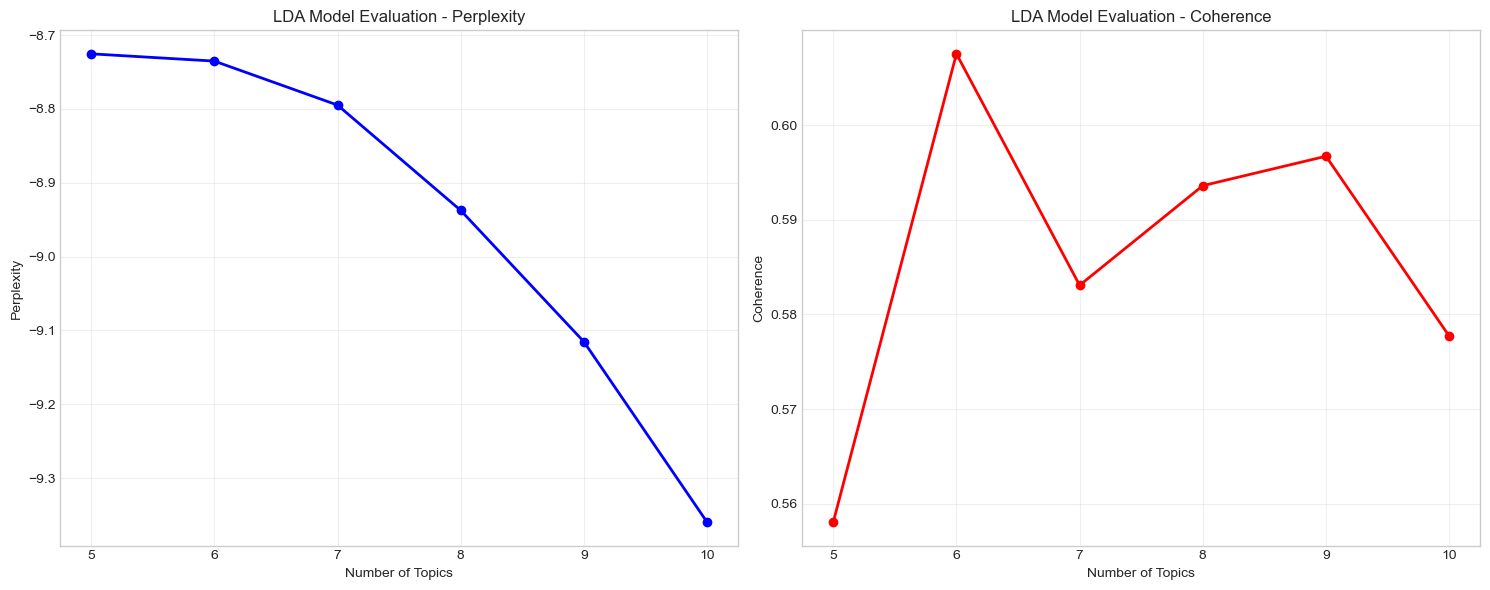


Optimal number of topics: 6 (coherence: 0.608)

Training final LDA model with 6 topics...


In [192]:
# Find optimal number of topics in English sample
corpus, dictionary, texts_lemmatized = preprocess_text_data(news_articles_eng)
topic_range, perplexities, coherences = find_optimal_topics(corpus, dictionary, texts_lemmatized, min_topics=5, max_topics=10)

eval_plot = plot_evaluation_metrics(topic_range, perplexities, coherences)
eval_plot.show()

# Select optimal number of topics (by highest coherence)
optimal_topics = topic_range[np.argmax(coherences)]
print(f"\nOptimal number of topics: {optimal_topics} (coherence: {max(coherences):.3f})")

# Train final LDA model
print(f"\nTraining final LDA model with {optimal_topics} topics...")
final_lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=optimal_topics,
    random_state=42,
    passes=20,
    alpha='auto',
    per_word_topics=True
)

Now let's take a look at the results:

In [195]:
# Let's take a look at the topic words:
print("Inspect the topics:")
for idx, topic in final_lda_model.print_topics(-1, num_words=10):
    print(f"Significant words for topic {idx+1}: {topic}")

# Get topic distributions for each article
print("\nCalculating topic distributions for each article...")
article_topic_distributions = []
for i, doc in enumerate(corpus):
    topic_dist = final_lda_model.get_document_topics(doc, minimum_probability=0.0)
    article_topic_distributions.append([prob for topic_id, prob in topic_dist])

# Convert to DataFrame
topic_dist_df = pd.DataFrame(article_topic_distributions, columns=[f'Topic_{i}' for i in range(optimal_topics)])

# Add article information
topic_dist_df['article_id'] = news_articles_eng.index
topic_dist_df['title'] = news_articles_eng['title'].values
topic_dist_df['body'] = news_articles_eng['body'].values

# But, of course, we are interested in identifying risk-factor-related topics!
print("\n=== Risk topic analysis ===")
# sample_keywords = ['food', 'hunger', 'famine', 'malnutrition', 'starvation', 'crisis', 'shortage', 'poverty', 'aid', 'relief']

def get_cluster_keywords(min_word_length=7):
    cluster_keywords = {}
    for i, row in merged_risk_factors[['risk_factor_english', 'cluster_english']].iterrows():
        for risk_factor in row['risk_factor_english'].split(' '):
            if len(risk_factor) >= min_word_length:
                cluster_keywords[row['cluster_english']] = cluster_keywords.get(row['cluster_english'], set()) | {risk_factor}
    return cluster_keywords

# List of risk factor keywords by cluster
cluster_keywords = get_cluster_keywords()

# All keywords
all_keywords = list(set(word for words in cluster_keywords.values() for word in words))

topic_risk_scores = []
for topic_id in range(optimal_topics):
    topic_words = final_lda_model.show_topic(topic_id, topn=100)
    topic_word_list = [word for word, prob in topic_words]
    
    # Calculate risk score based on keyword overlap
    risk_score = sum(1 for word in topic_word_list if word in all_keywords)
    topic_risk_scores.append(risk_score)
    
    print(f"Topic {topic_id}: Risk Score = {risk_score}")
    print(f" - Top words: {', '.join([word for word, prob in topic_words[:10]])}")

# Identify the most risk-factor-related topic
risk_topic_id = np.argmax(topic_risk_scores)
print(f"\nMost risk-factor-related topic: Topic {risk_topic_id} (score: {topic_risk_scores[risk_topic_id]})")

# Filter articles based on risk topic probability
risk_topic_col = f'Topic_{risk_topic_id}'
mean_risk_prob = topic_dist_df[risk_topic_col].mean()
std_risk_prob = topic_dist_df[risk_topic_col].std()

print(f"\nMean probability for risk topic: {mean_risk_prob:.3f}")

# Apply filtering heuristics
filtered_articles = topic_dist_df[
    (topic_dist_df[risk_topic_col] > 0) &  # Non-zero probability
    (topic_dist_df[risk_topic_col] >= mean_risk_prob + 2 * std_risk_prob) &  # Above mean
    (topic_dist_df[risk_topic_col] == topic_dist_df[[f'Topic_{i}' for i in range(optimal_topics)]].max(axis=1))  # Highest probability
]

print(f"Filtered articles: {len(filtered_articles)} out of {len(topic_dist_df)}")

# Save filtered articles results
topic_dist_df.to_csv(os.path.join(INTERMEDIATE_DIR, 'article_topic_distributions.csv'), index=False)
filtered_articles.to_csv(os.path.join(INTERMEDIATE_DIR, 'risk_related_articles.csv'), index=False)

Inspect the topics:
Significant words for topic 1: 0.017*"party" + 0.013*"election" + 0.010*"france" + 0.010*"president" + 0.009*"vote" + 0.009*"macron" + 0.008*"french" + 0.008*"trump" + 0.007*"government" + 0.007*"right"
Significant words for topic 2: 0.036*"israel" + 0.036*"palestinian" + 0.031*"gaza" + 0.021*"israeli" + 0.010*"people" + 0.010*"jewish" + 0.010*"international" + 0.010*"palestine" + 0.008*"child" + 0.007*"war"
Significant words for topic 3: 0.009*"people" + 0.005*"family" + 0.005*"police" + 0.004*"life" + 0.004*"day" + 0.004*"city" + 0.004*"child" + 0.004*"woman" + 0.003*"court" + 0.003*"told"
Significant words for topic 4: 0.006*"country" + 0.004*"world" + 0.004*"new" + 0.004*"company" + 0.004*"state" + 0.003*"international" + 0.003*"government" + 0.003*"russia" + 0.003*"support" + 0.003*"global"
Significant words for topic 5: 0.026*"israel" + 0.025*"israeli" + 0.021*"gaza" + 0.018*"hamas" + 0.018*"military" + 0.017*"war" + 0.015*"attack" + 0.012*"killed" + 0.009*"fo

We can now more easily manually take a look at the most ($z > 2$) risk-factor-relevant articles. We see that they mostly concern (understandably) the crisis in Gaza.

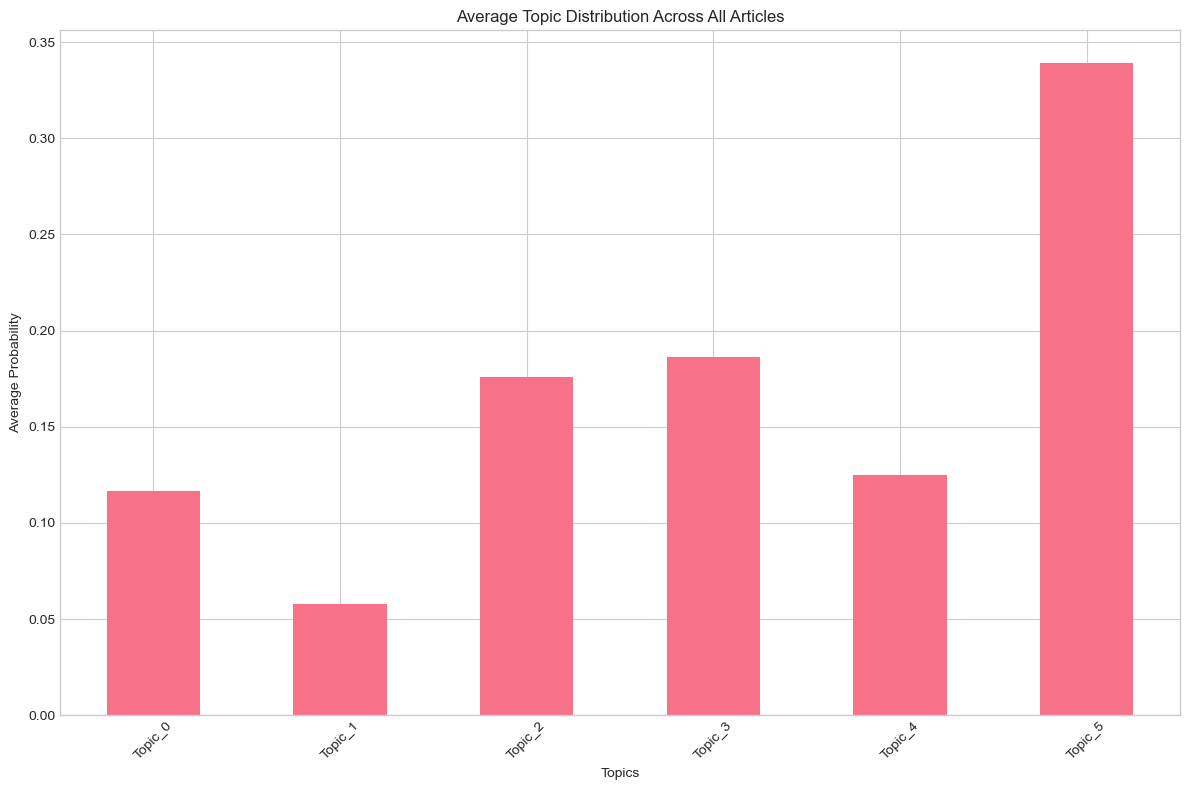

In [ ]:
# Create visualization of topic distributions
fig, ax = plt.subplots(figsize=(12, 8))
topic_dist_df[[f'Topic_{i}' for i in range(optimal_topics)]].mean().plot(kind='bar', ax=ax)
ax.set_xlabel('Topics')
ax.set_ylabel('Average Probability')
ax.set_title('Average Topic Distribution Across All Articles')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'topic_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

Going forward, I would use a topic modelling approach to cluster based on pre-determined risk-factor clusters (if those are most relevant to our team) to narrow data scope and guide analysis. Moreover, we could use unsupervised clustering techniques to find novel patterns, i.e. new themes and keywords that we have not yet accounted for and are potentially overlooking. Obviously, I would also look into similar approaches for Arabic-language text for the same reasons highlighted above.

Due to time constraints, will leave this open-ended analysis here...

---